Dataset used:
https://www.kaggle.com/datasets/nelgiriyewithana/emotions?resource=download

In [10]:
import numpy as np
import pandas as pd
import re
import nltk
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neural_network import BernoulliRBM
from sklearn.decomposition import TruncatedSVD
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import math
import joblib
from time import time

In [26]:
n_samples = 2000
n_features = 2000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lilia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lilia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lilia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [18]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
def preprocess(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@[\w_]+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)         # Remove hashtag symbol
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.lower()                  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    return text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])

def get_data(path,col,nrows):
    df = pd.read_csv(path, usecols=[col],dtype=str, nrows=nrows)
    text_data = df[col].dropna()
    text_data = text_data.apply(preprocess)
    text_data = text_data.apply(remove_stopwords)
    text_data = text_data.apply(lemmatize_text)
    return text_data

In [28]:
def fit_models(tfidfs, tfs, tfidf_vecotrizer, tf_vectorizer, data_set_name):
    t0 = time()
    nmf = NMF(
        n_components=n_components,
        random_state=1,
        init=init,
        beta_loss="kullback-leibler",
        solver="mu",
        max_iter=1000,
        alpha_W=0.00005,
        alpha_H=0.00005,
        l1_ratio=0.5,
    ).fit(tfidfs)
    print("done in %0.3fs." % (time() - t0))
    joblib.dump(nmf,"exports/topic_extractor.pkl")
    print("model saved")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    plot_top_words(
        nmf,
        tfidf_feature_names,
        n_top_words,
        "Topics in NMF model (generalized Kullback-Leibler divergence)" + data_set_name,
    )
    
    lda = LatentDirichletAllocation(
        n_components=n_components,
        max_iter=5,
        learning_method="online",
        learning_offset=50.0,
        random_state=0,
    )
    t0 = time()
    lda.fit(tfidfs)
    print("done in %0.3fs." % (time() - t0))
    
    feature_names = tfidf_vectorizer.get_feature_names_out()
    plot_top_words(lda, feature_names, n_top_words, "Topics in LDA model (tfidf)" + data_set_name)
    
    lda = LatentDirichletAllocation(
        n_components=n_components,
        max_iter=5,
        learning_method="online",
        learning_offset=50.0,
        random_state=0,
    )
    t0 = time()
    lda.fit(tfs)
    print("done in %0.3fs." % (time() - t0))
    
    feature_names = tf_vectorizer.get_feature_names_out()
    plot_top_words(lda, feature_names, n_top_words, "Topics in LDA model (tf)" + data_set_name)

(18356, 2000)
(18356, 2000)
done in 5.563s.


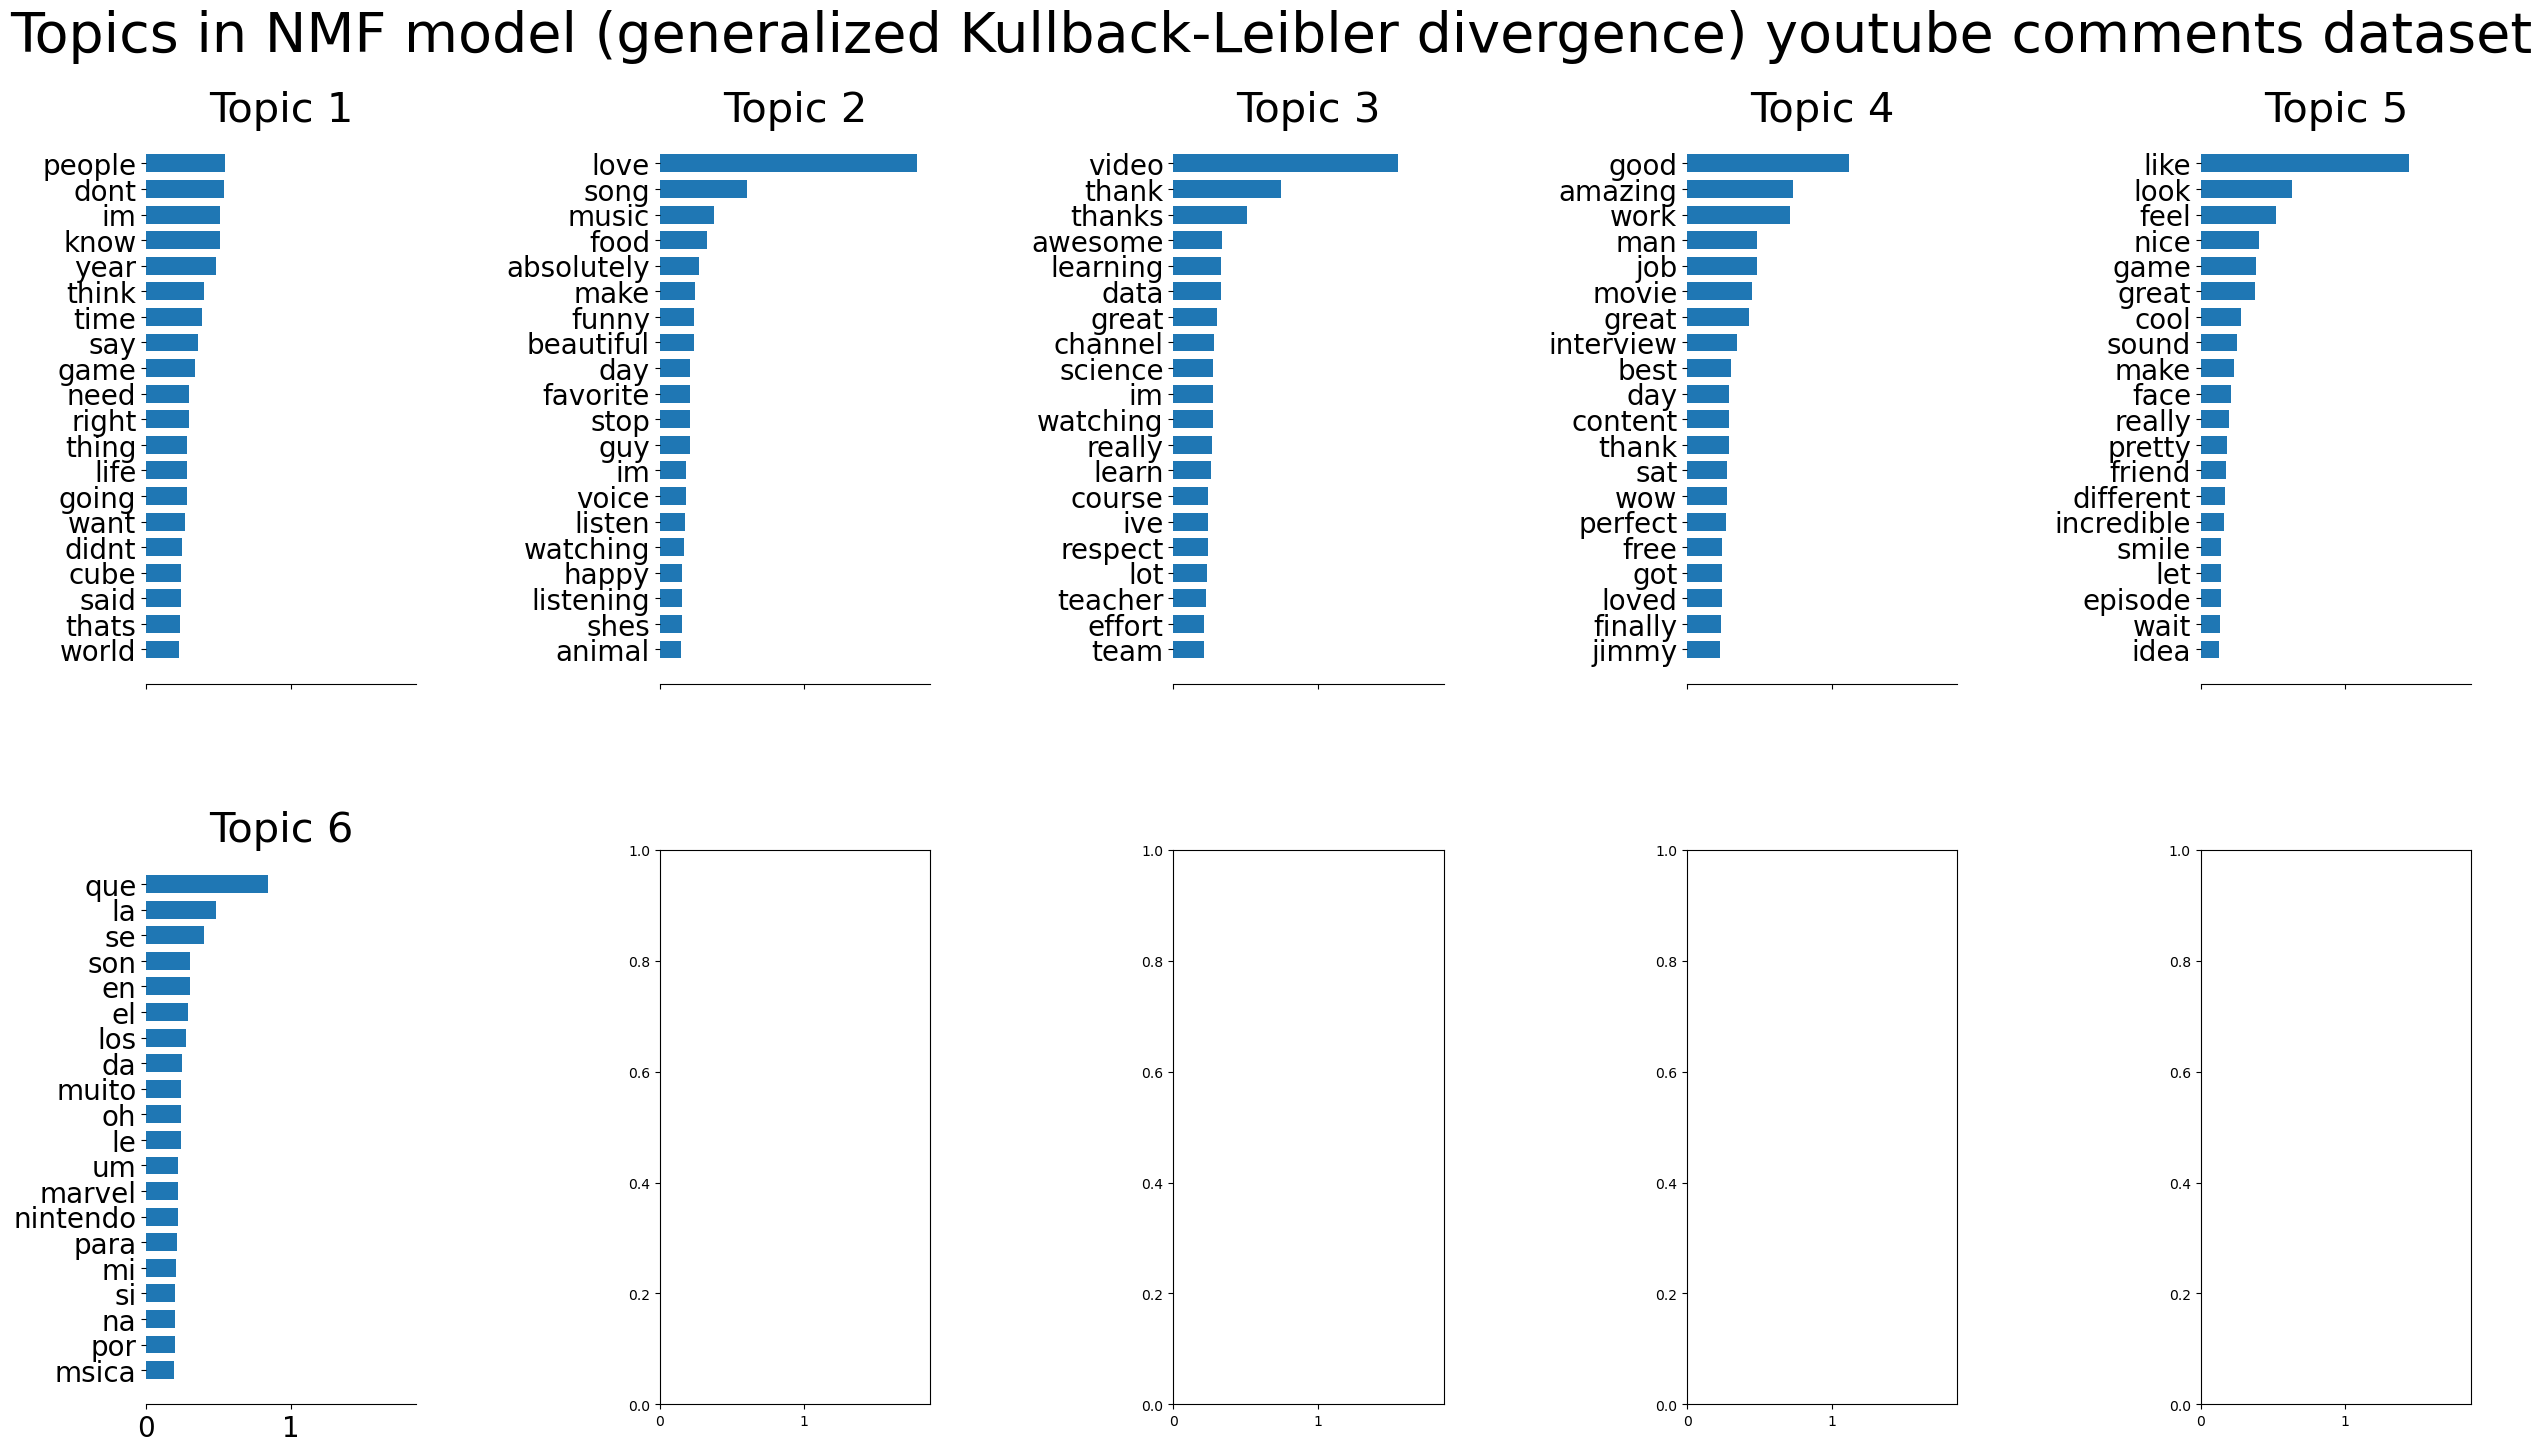

done in 9.177s.


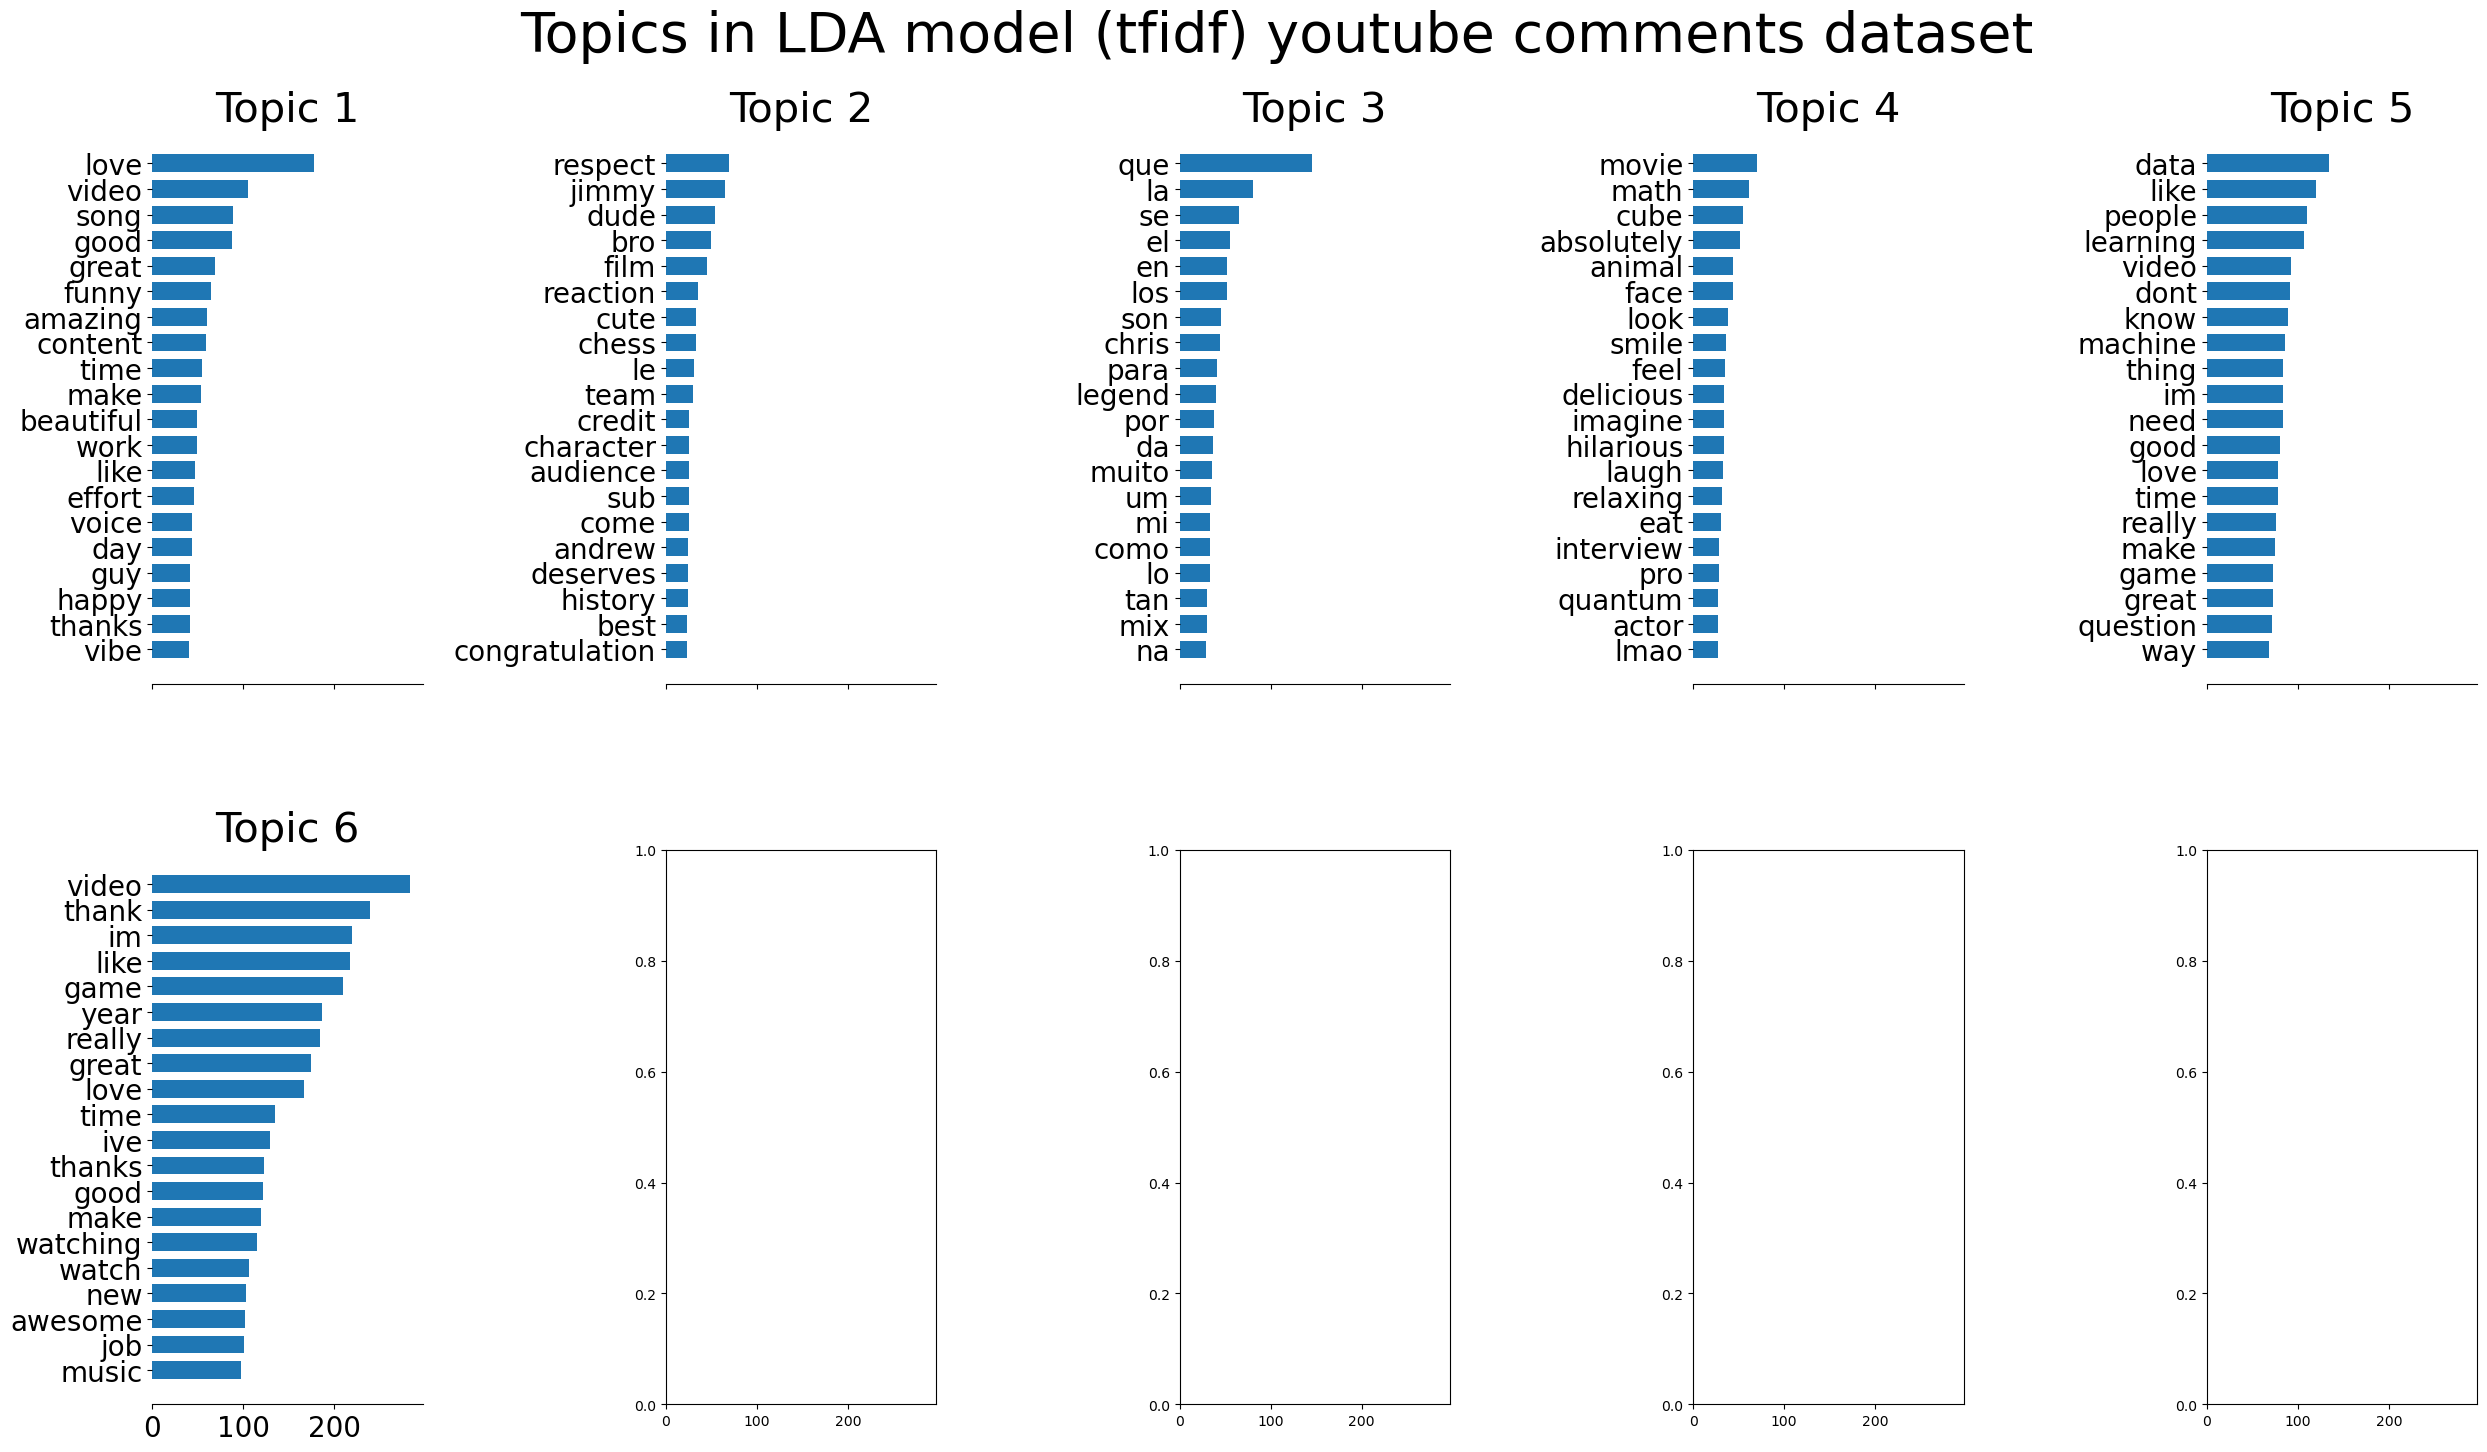

done in 11.490s.


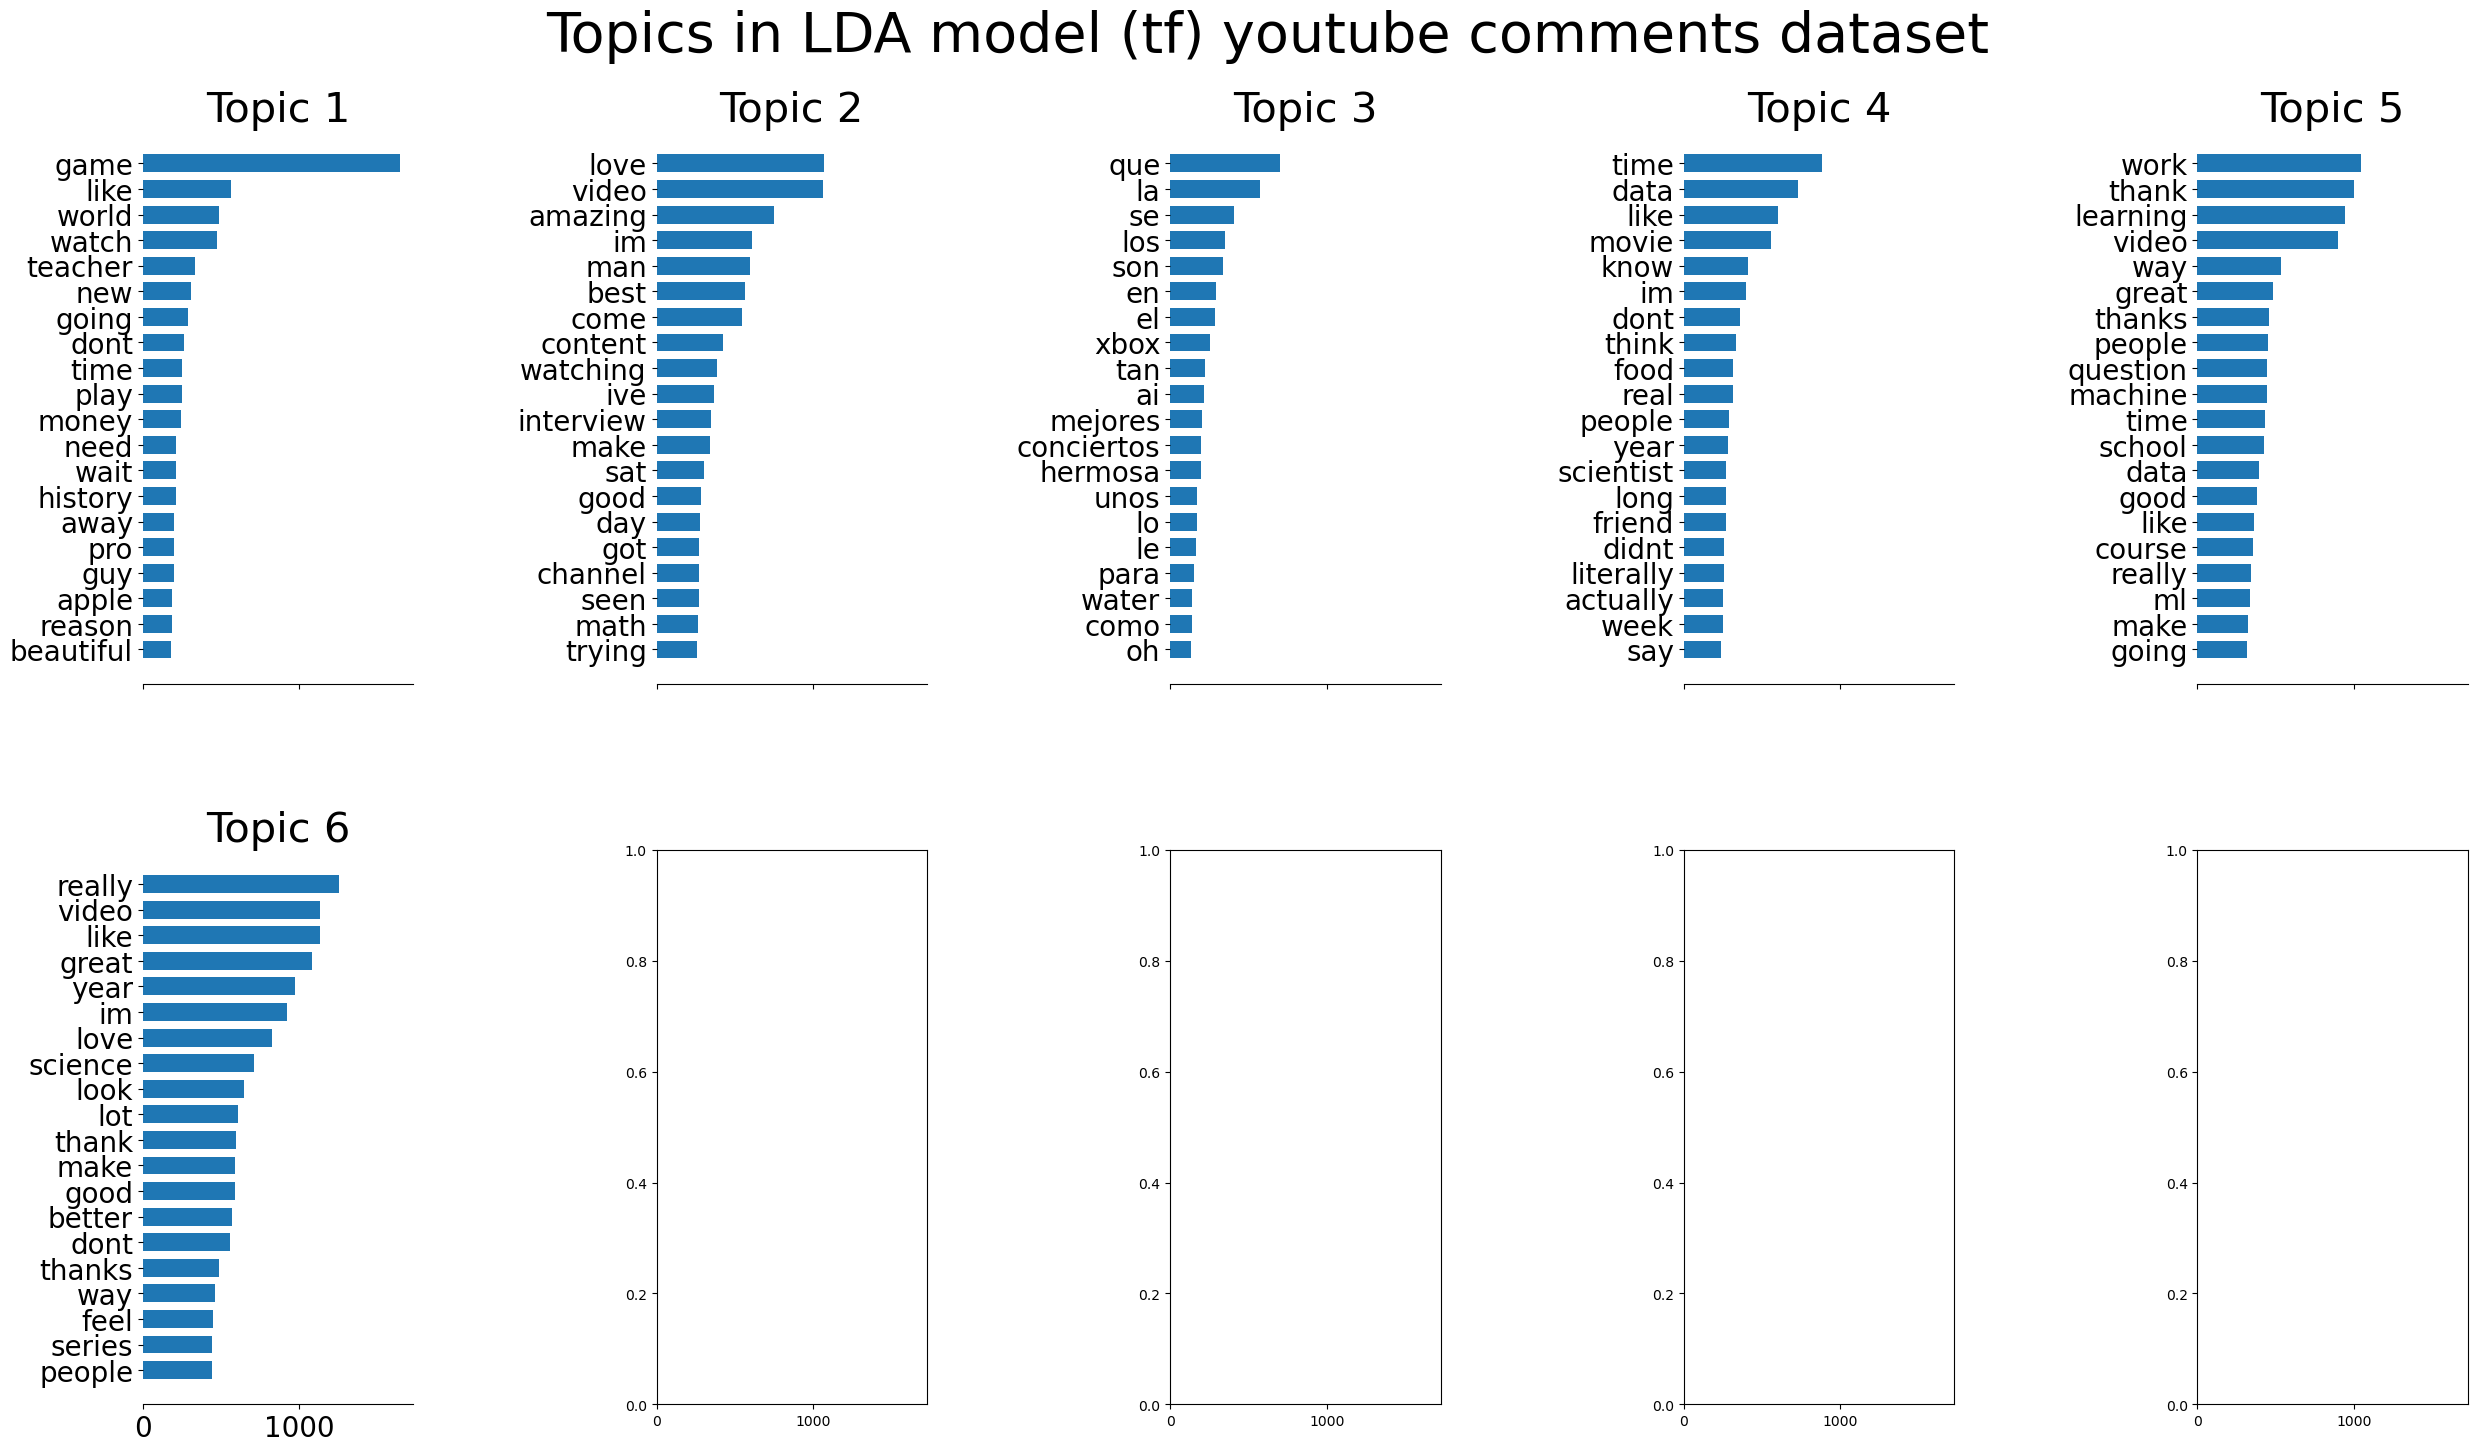

In [17]:
text_data = get_data('text_data/yt_comments.csv','Comment',18400)
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tfidf = tfidf_vectorizer.fit_transform(text_data)

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tf = tf_vectorizer.fit_transform(text_data)

print(tfidf.shape)
print(tf.shape)
#joblib.dump(vectorizer,"exports/text_vectorizer.pkl")
fit_models(tfidf,tf,tfidf_vectorizer,tf_vectorizer, " youtube comments dataset")

topic extraction using different method parameters

(400000, 2000)
(400000, 2000)
done in 86.301s.


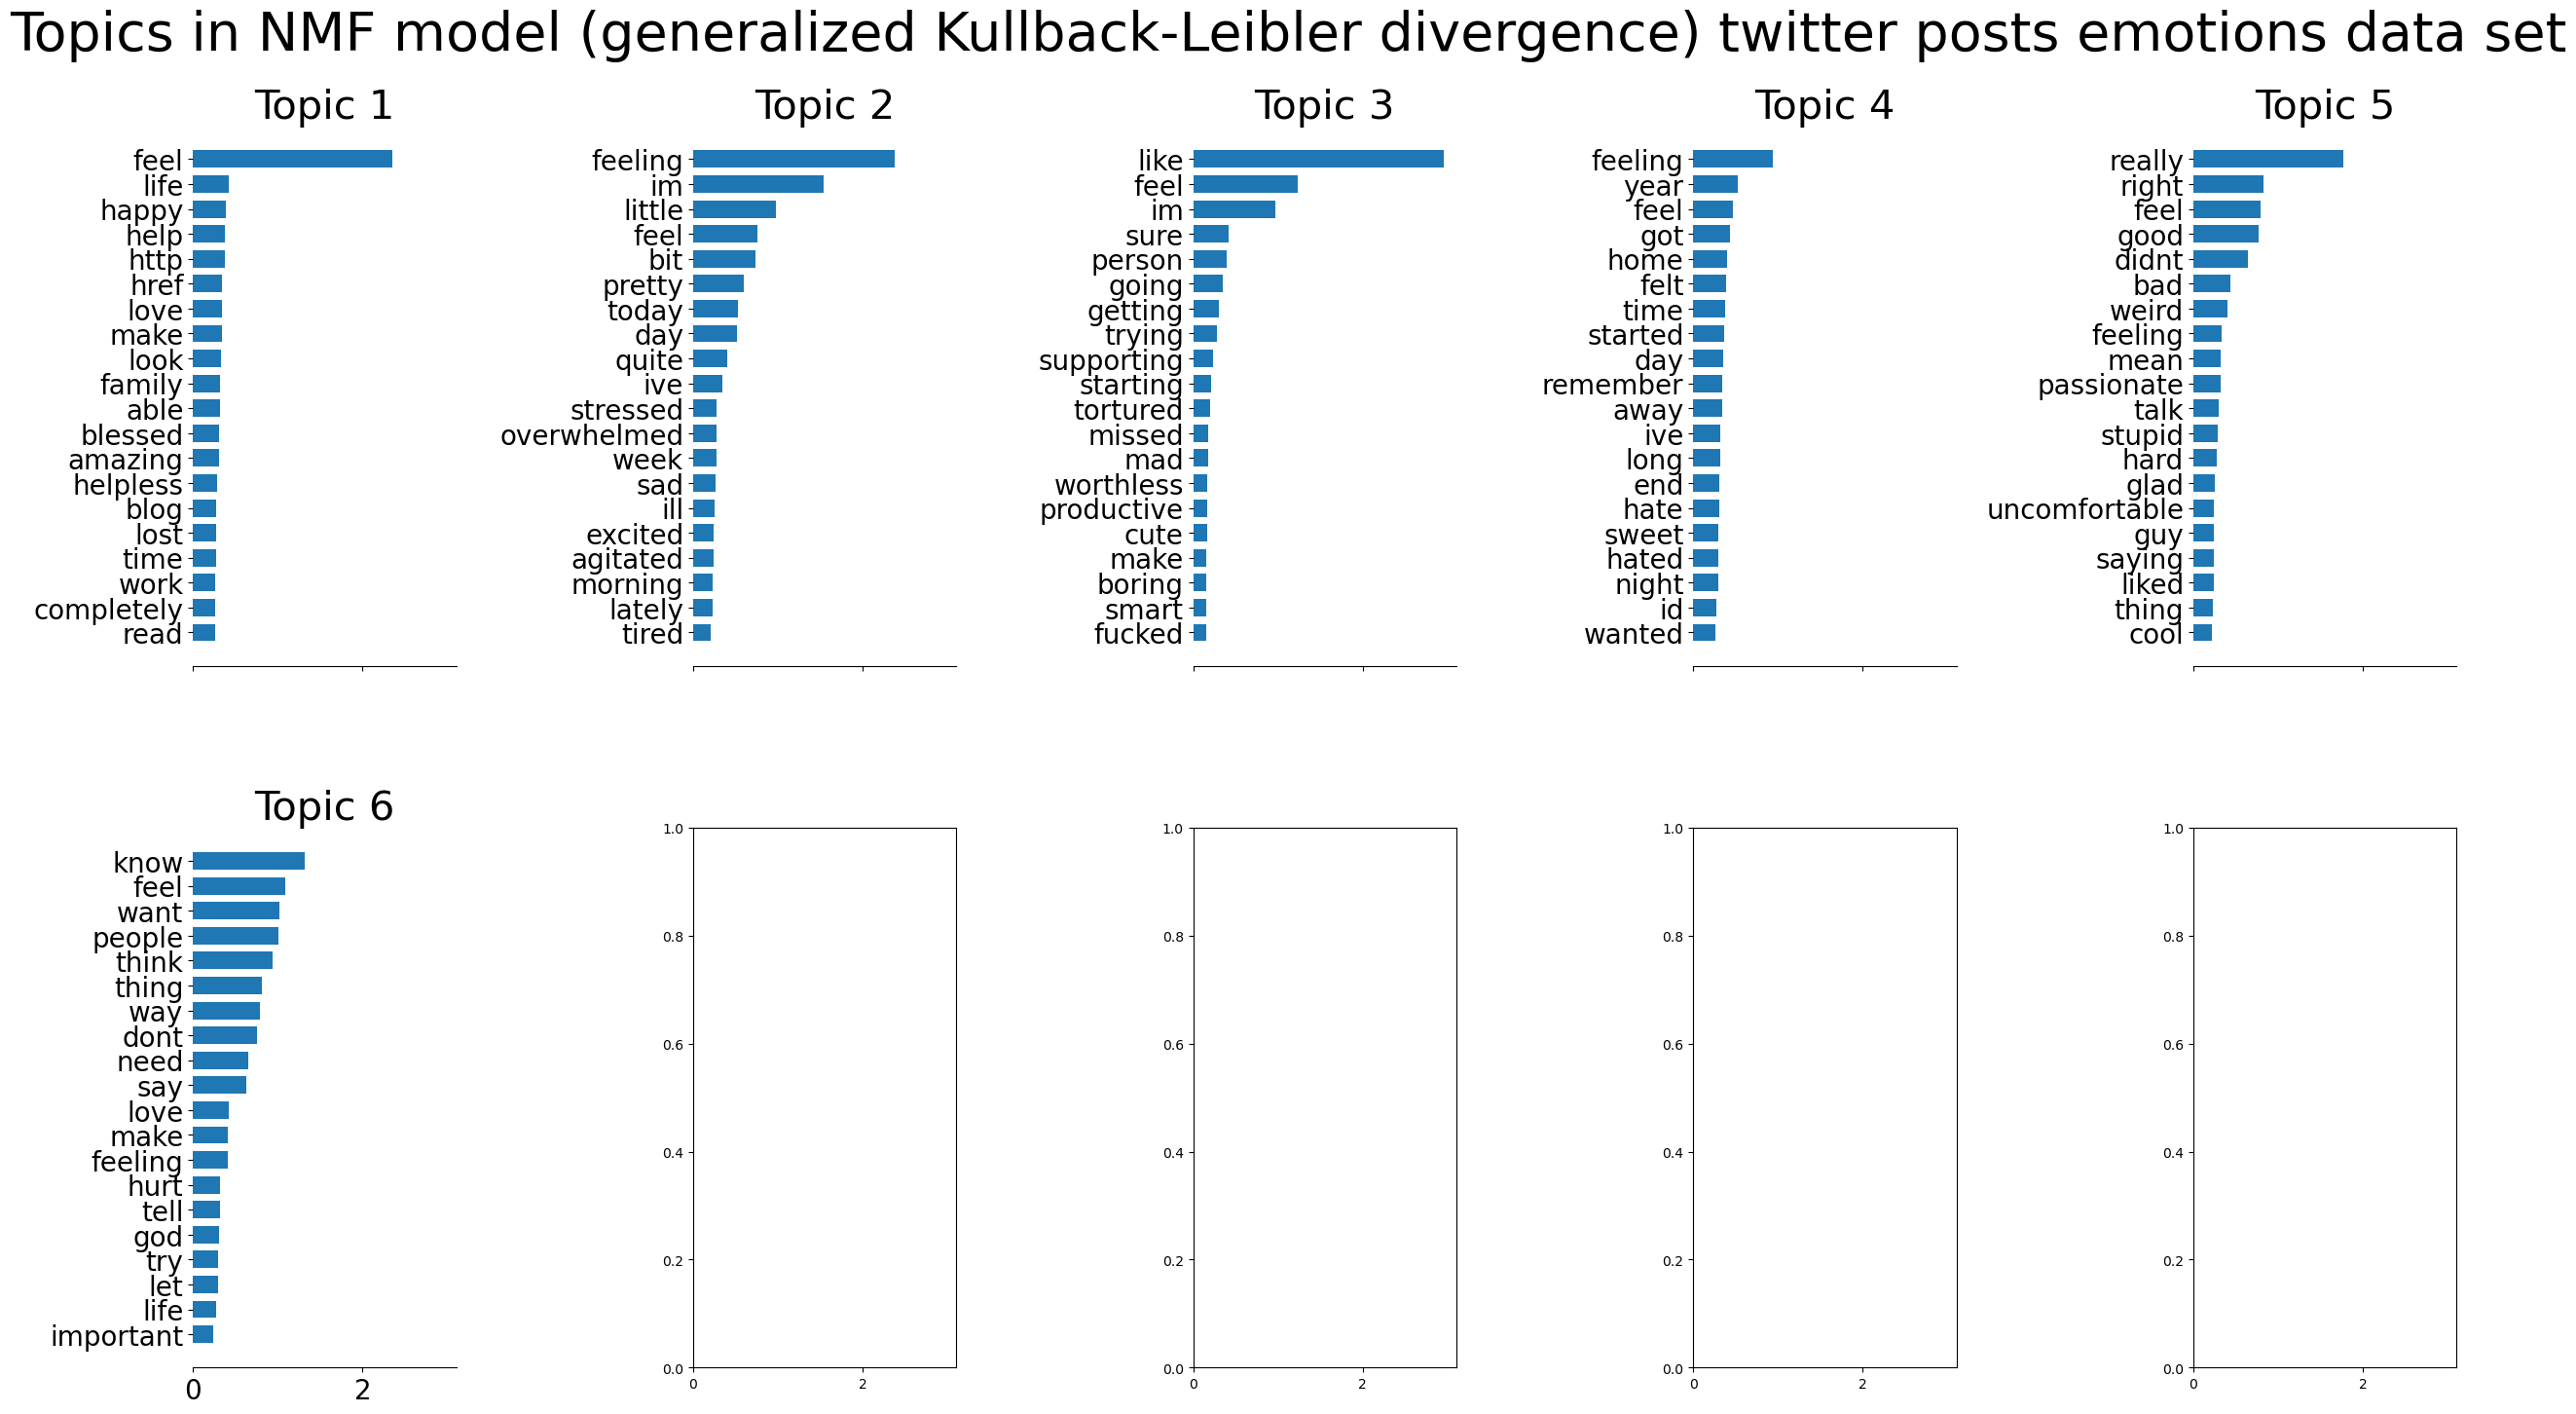

done in 151.212s.


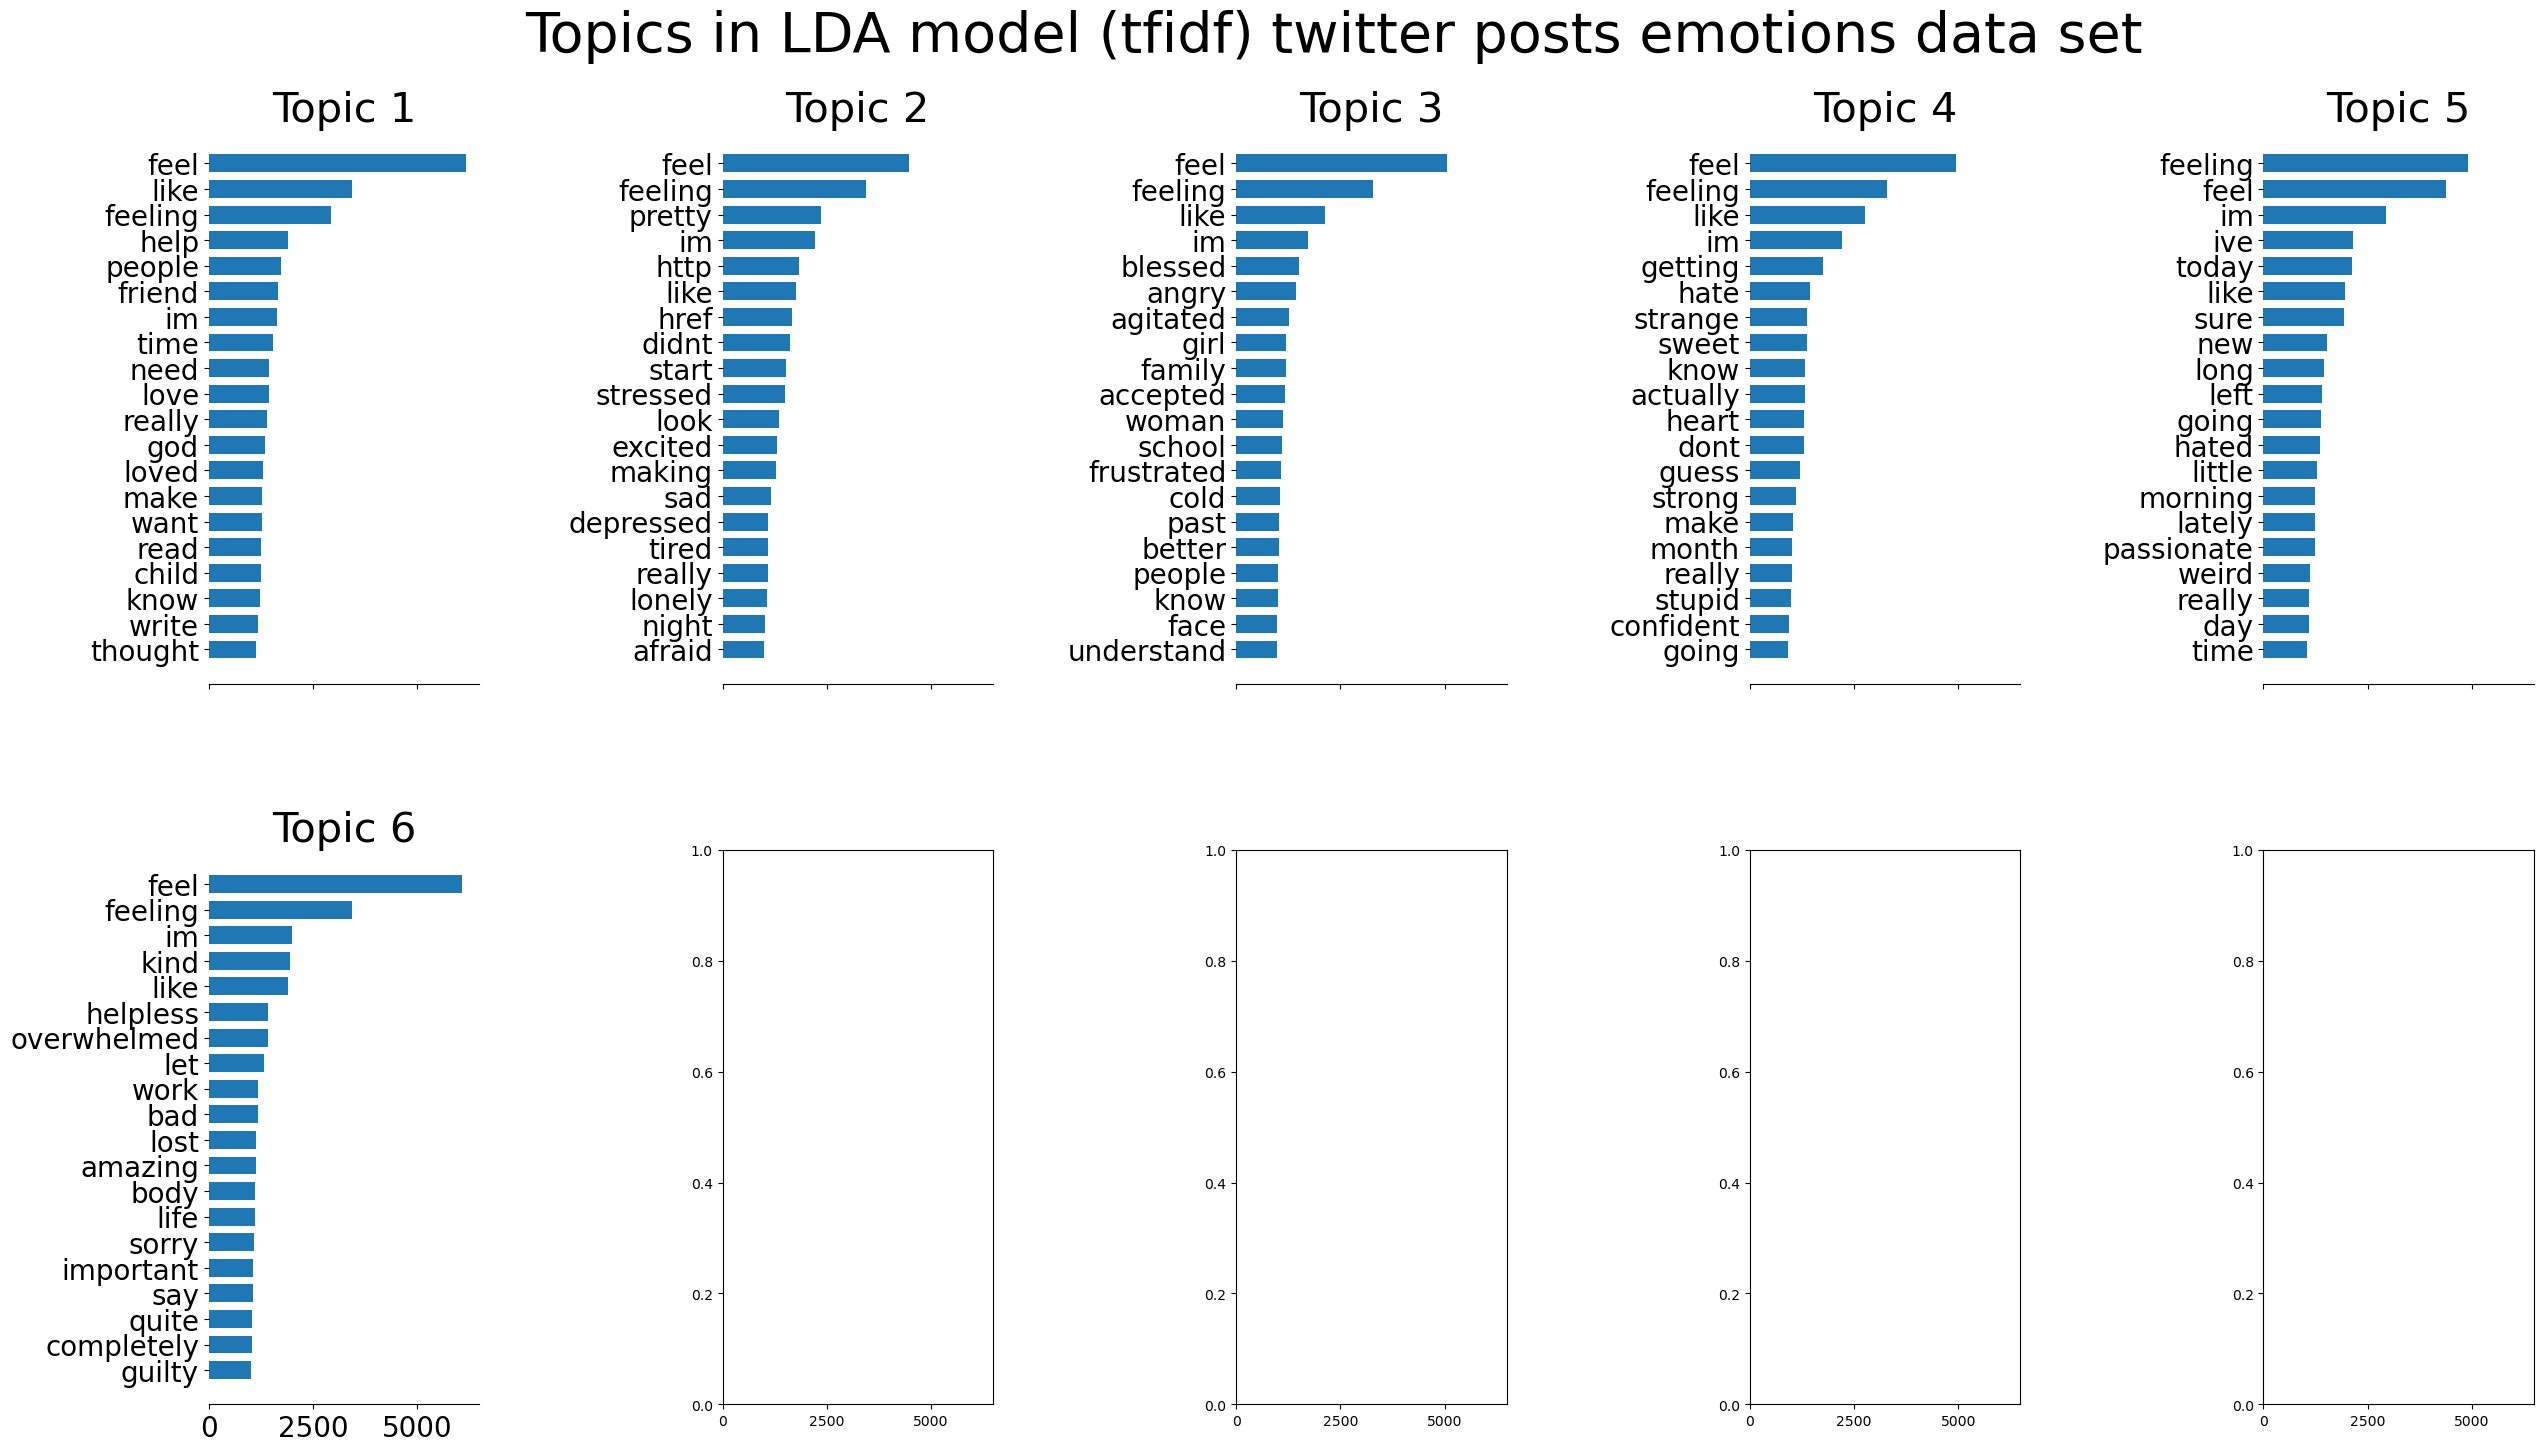

done in 196.889s.


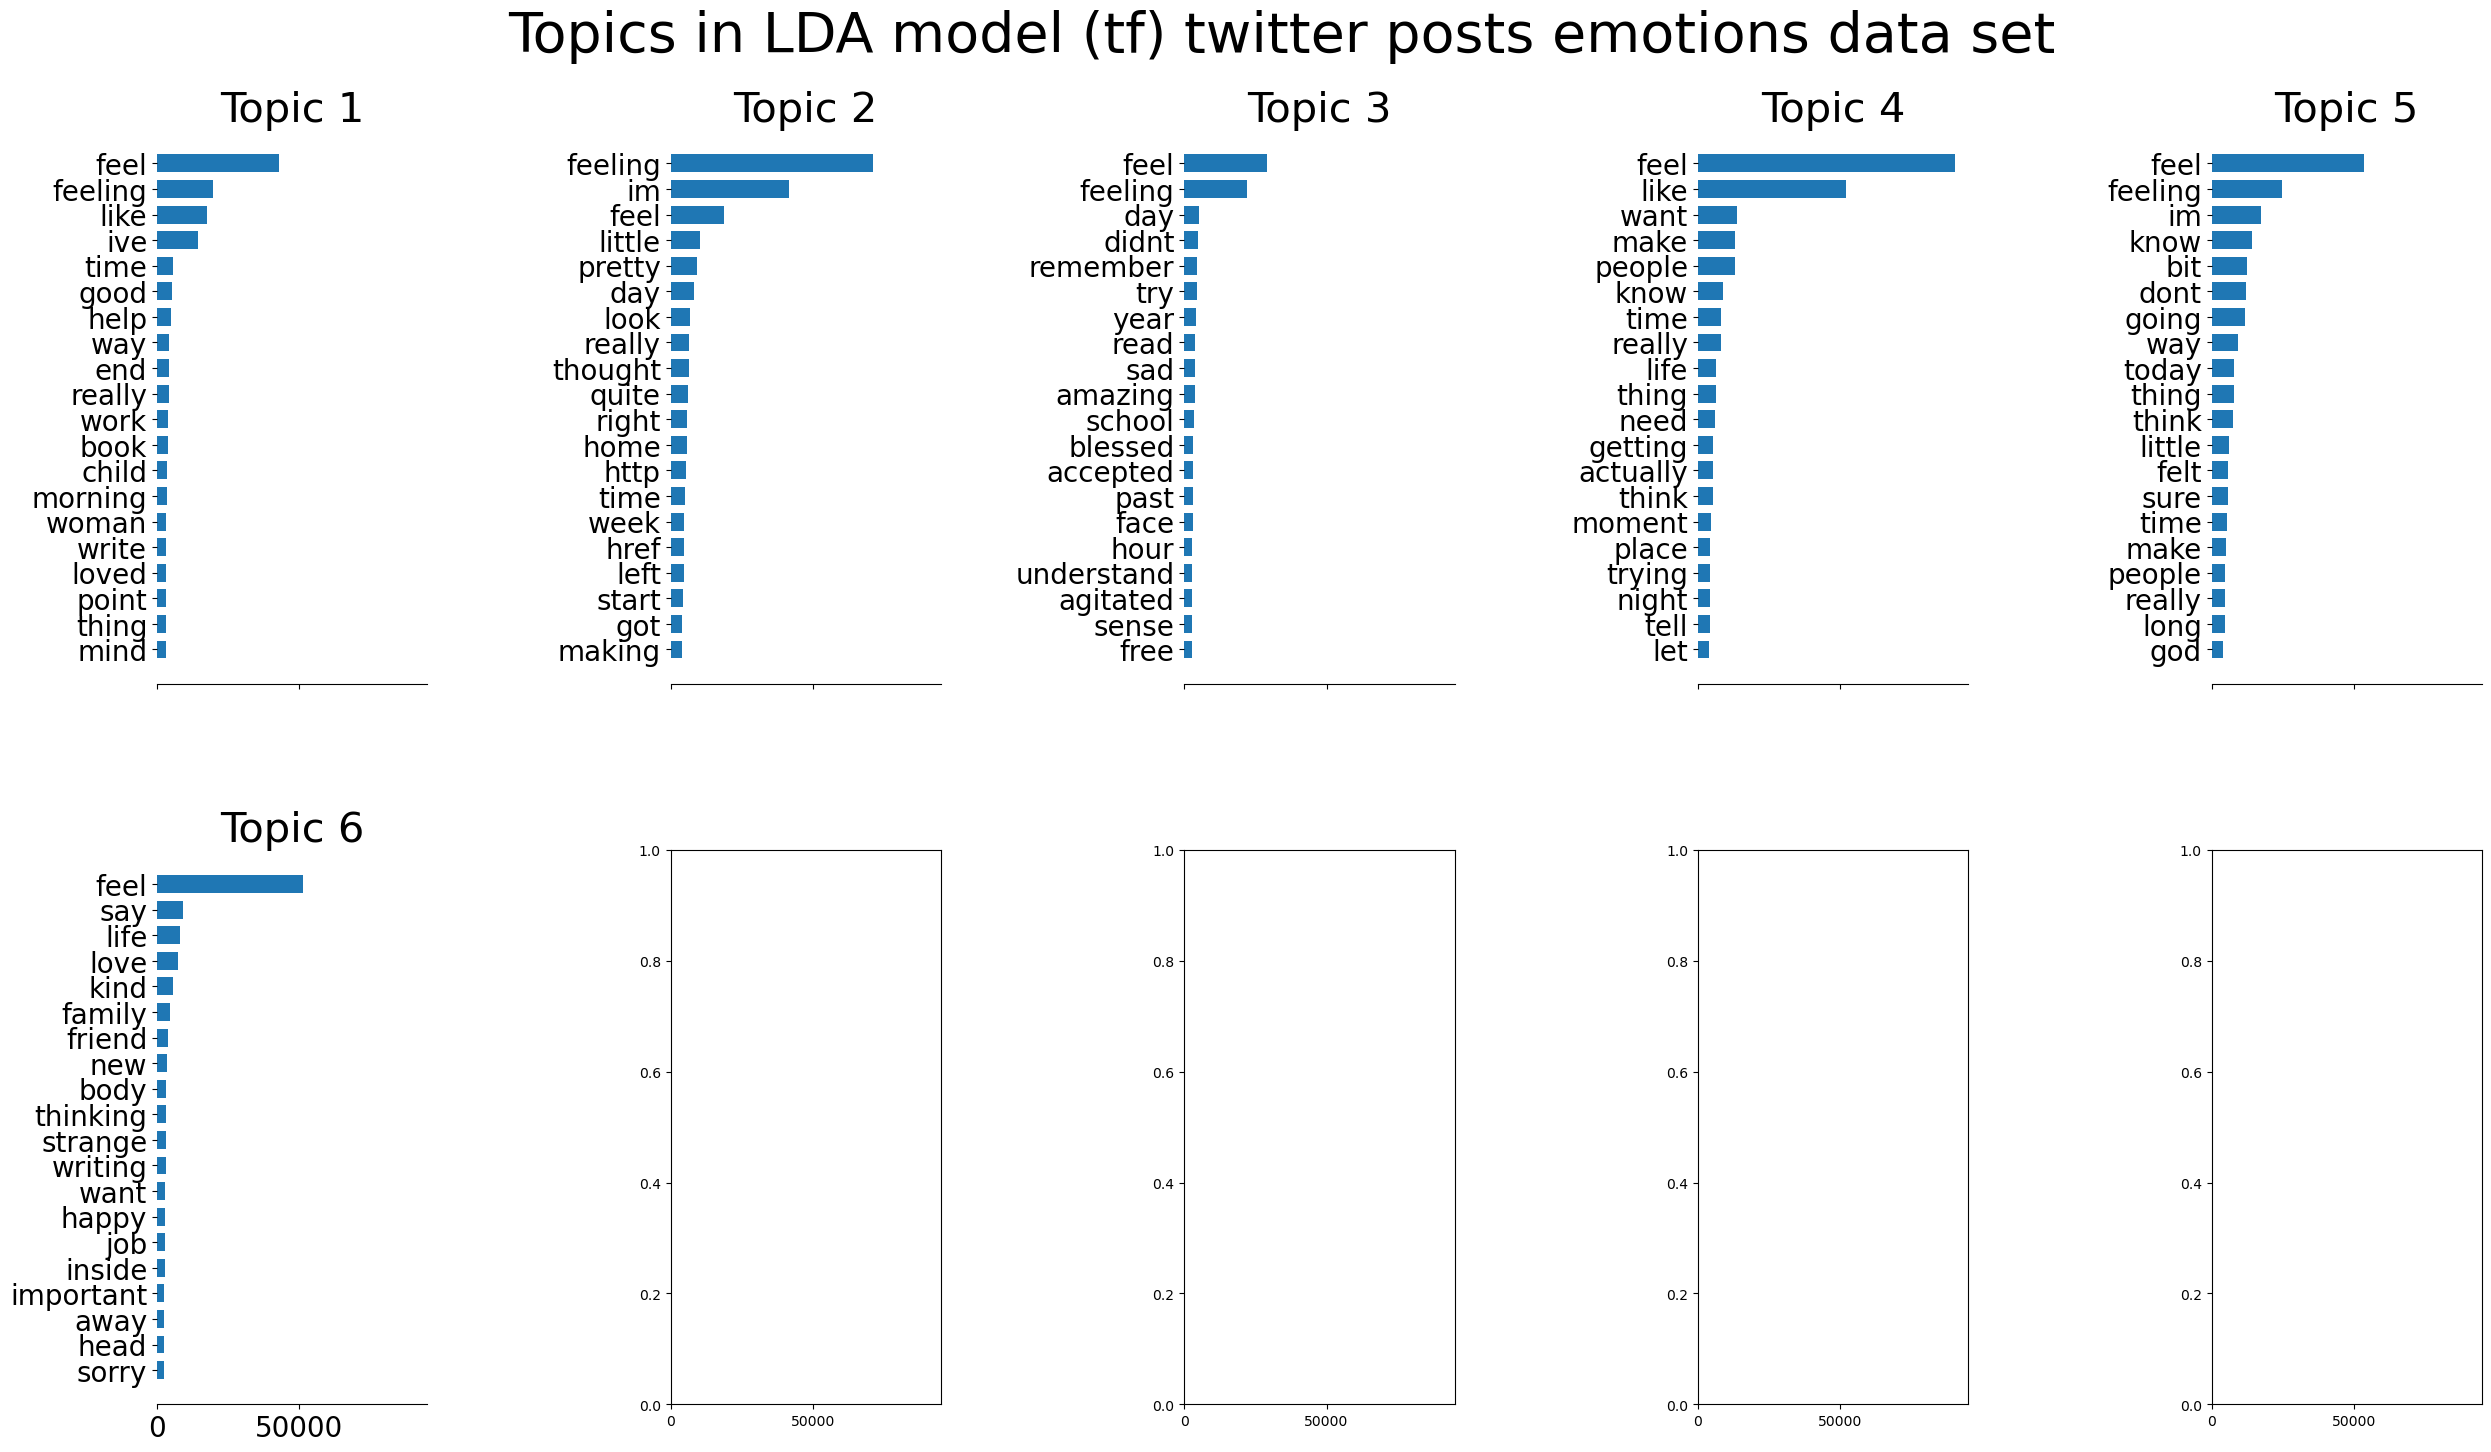

In [20]:
text_data = get_data('text_data/twitter_posts_emotions.csv','text',400000)
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tfidf = tfidf_vectorizer.fit_transform(text_data)

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tf = tf_vectorizer.fit_transform(text_data)

print(tfidf.shape)
print(tf.shape)
#joblib.dump(vectorizer,"exports/text_vectorizer.pkl")
fit_models(tfidf,tf,tfidf_vectorizer,tf_vectorizer, " twitter posts emotions data set")

(20000, 2000)
(20000, 2000)
done in 1.598s.


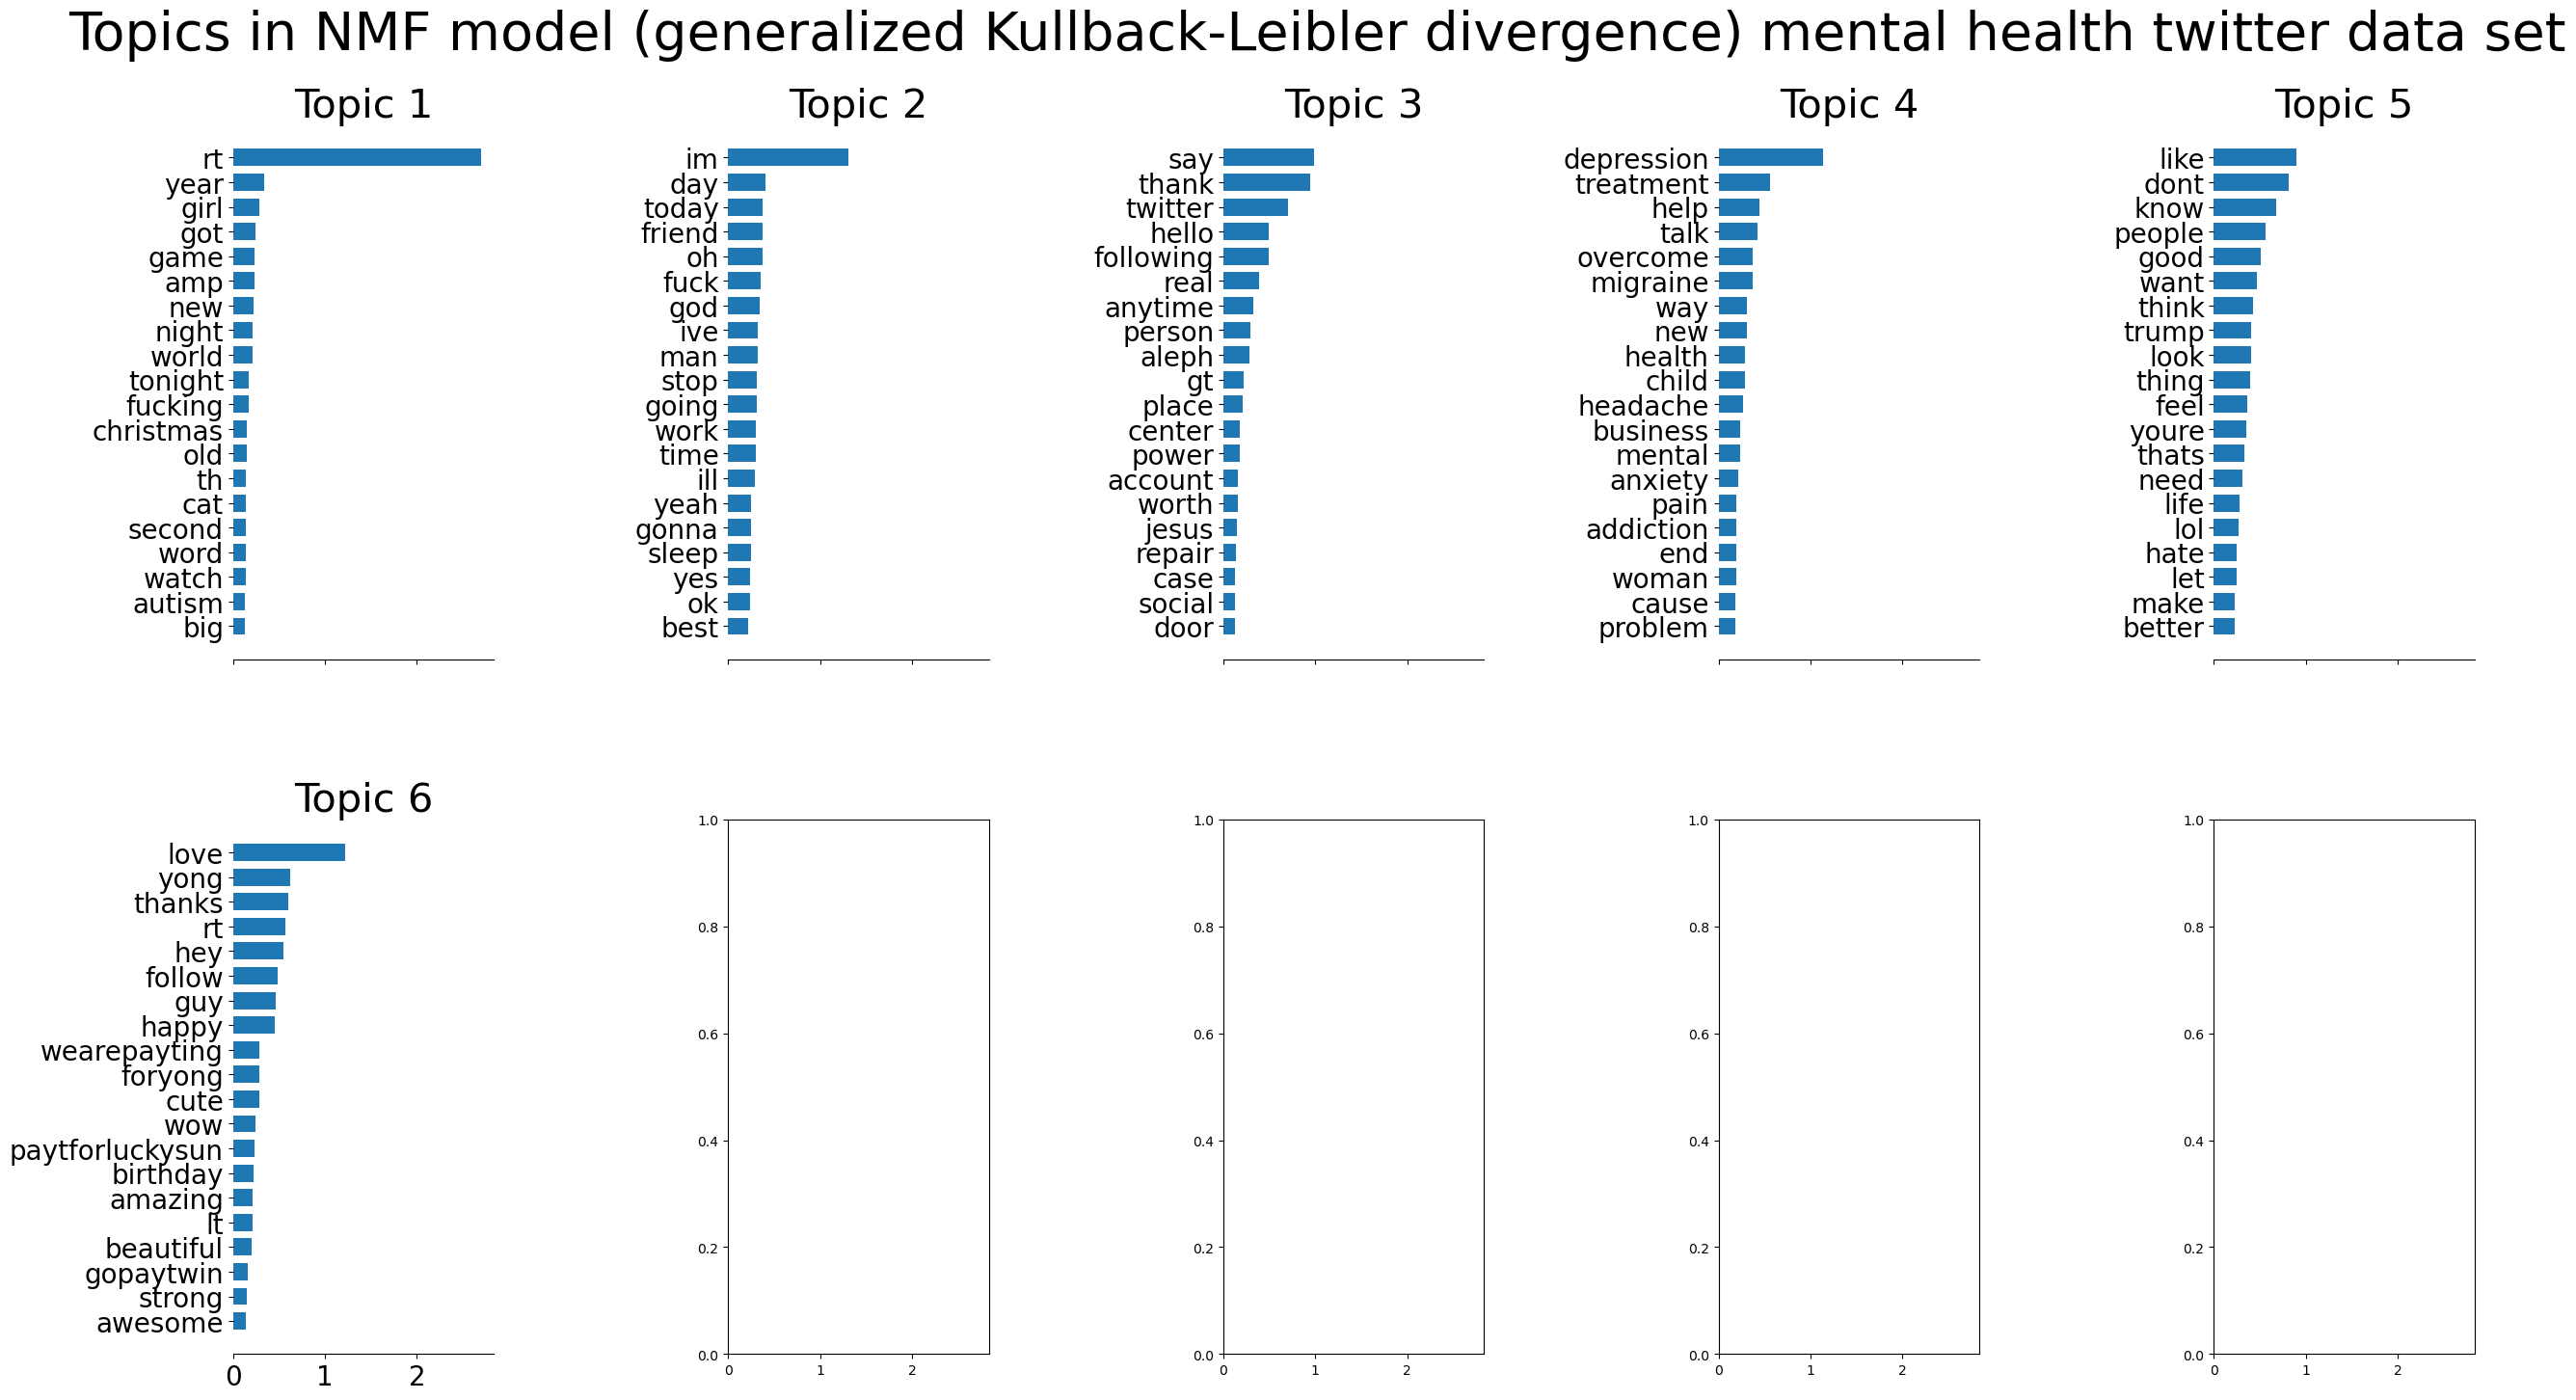

done in 6.665s.


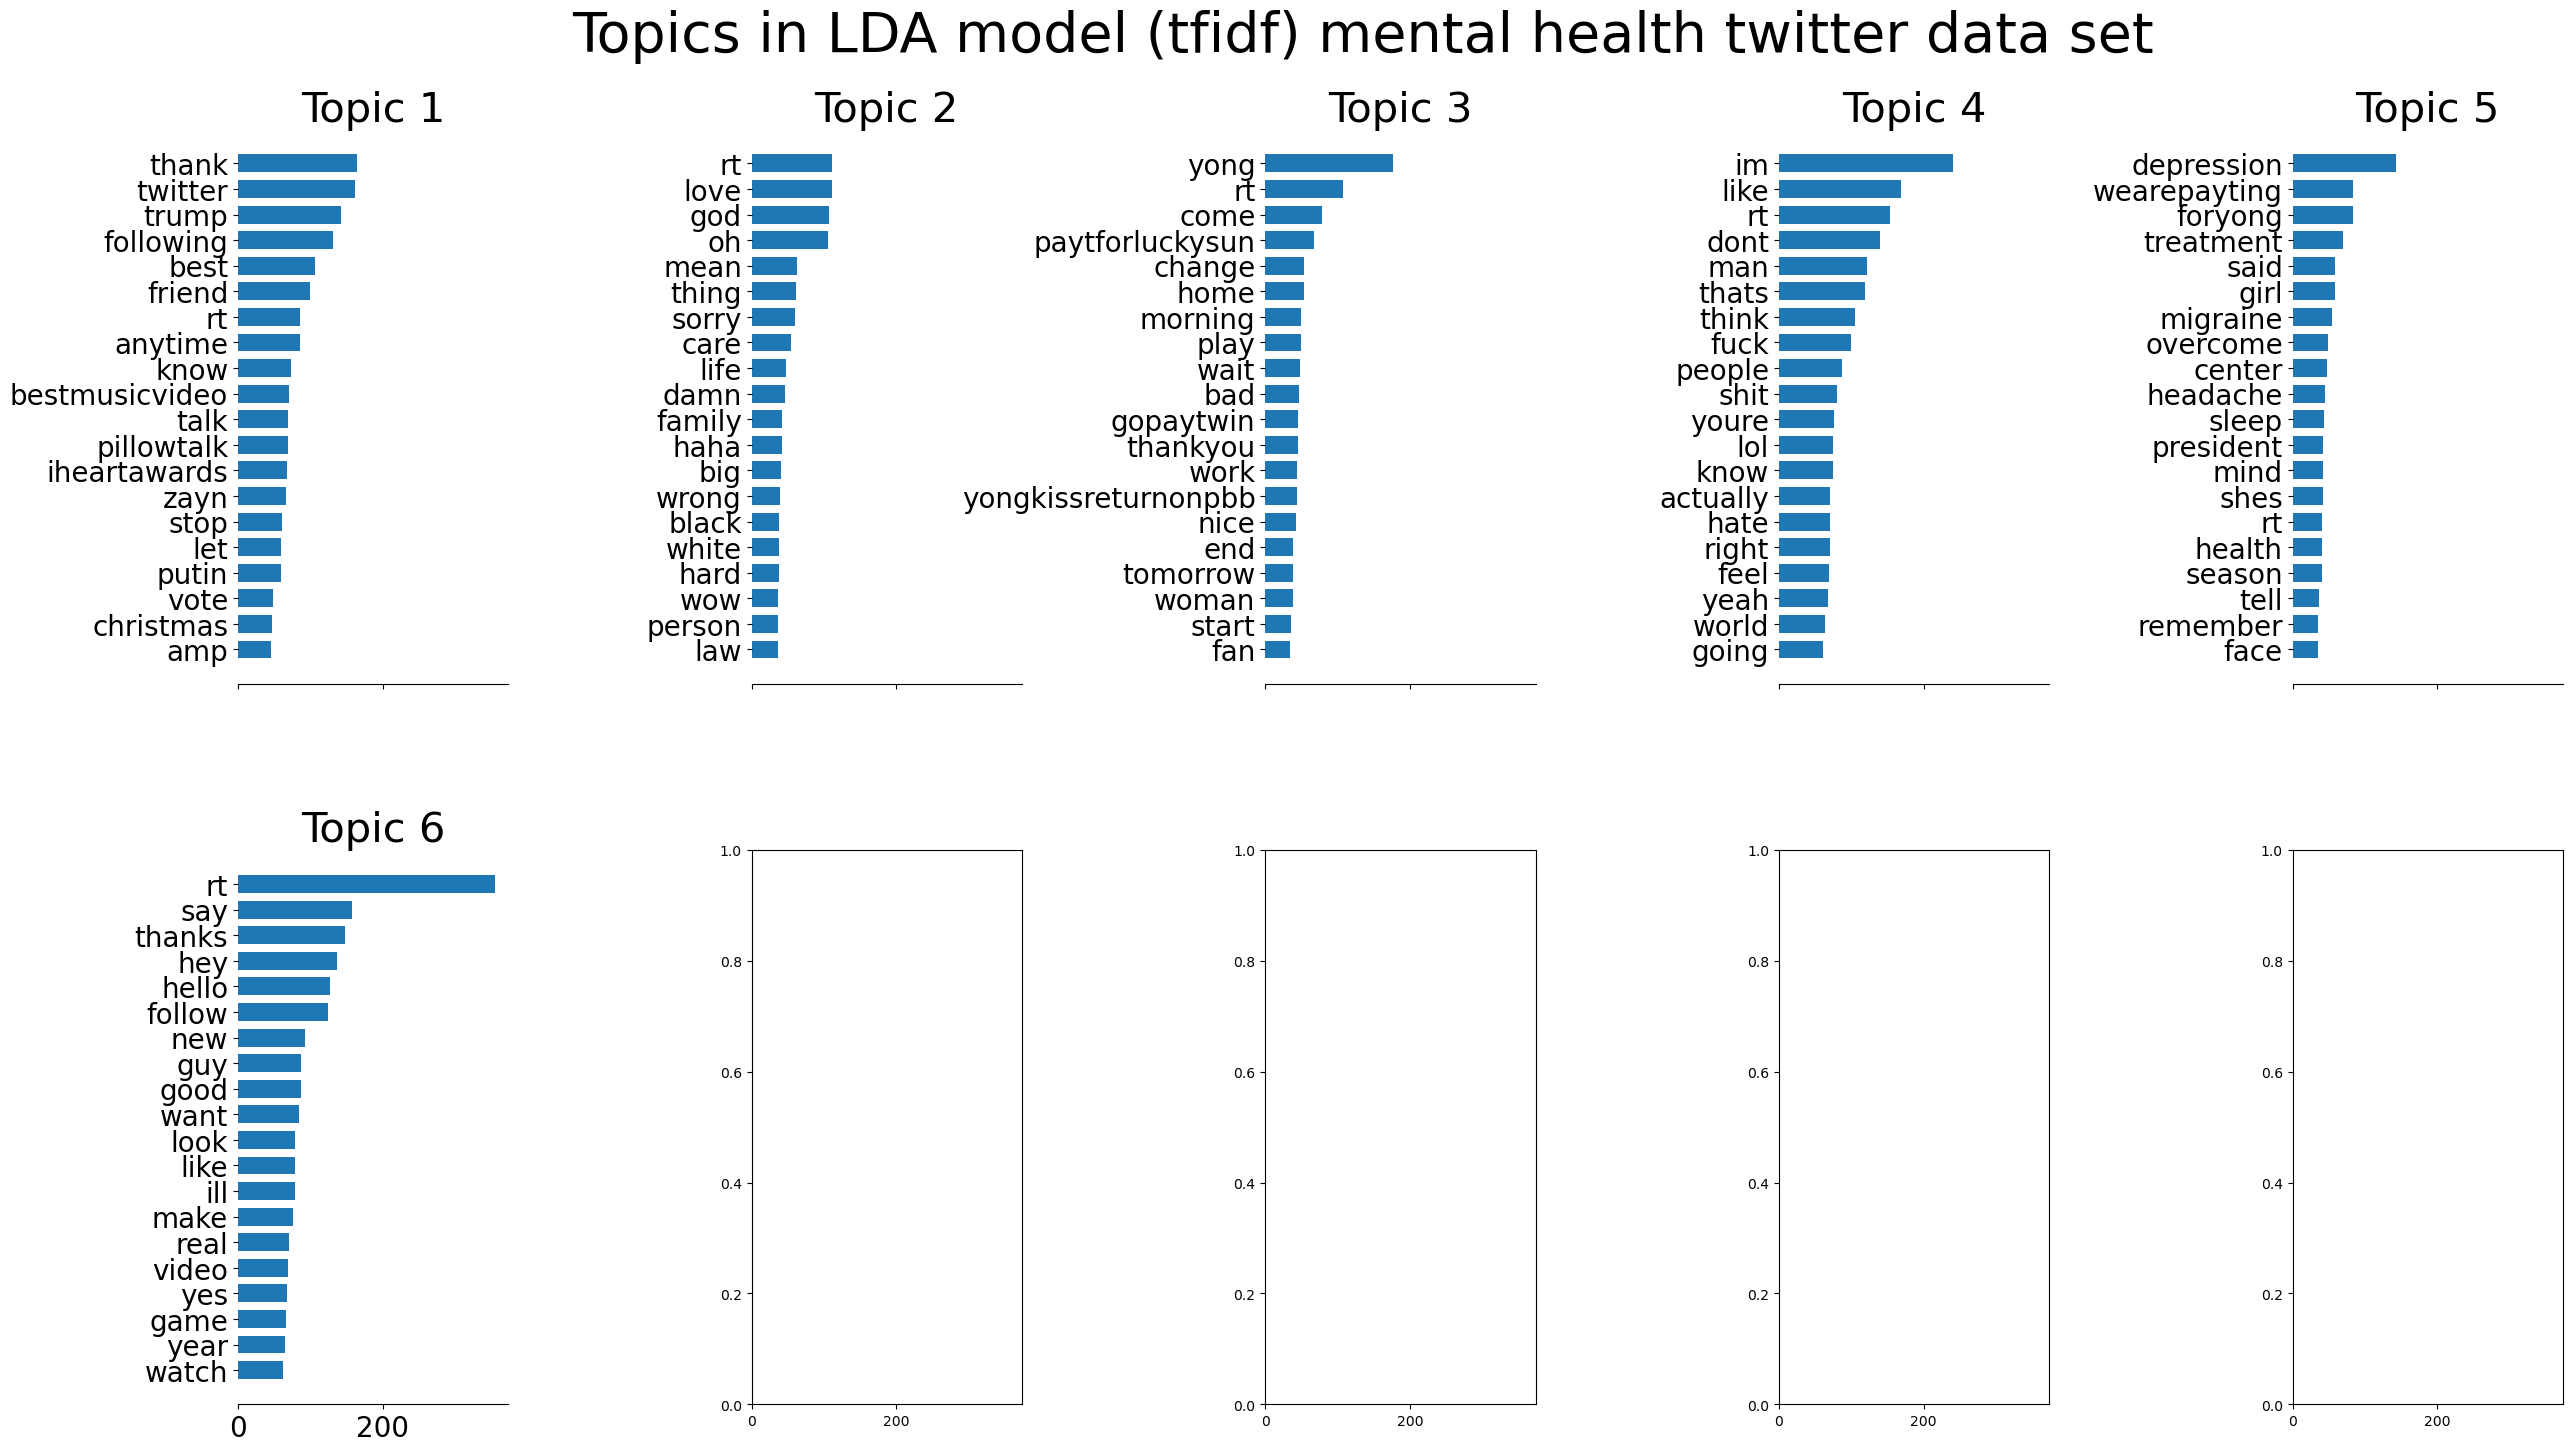

done in 7.228s.


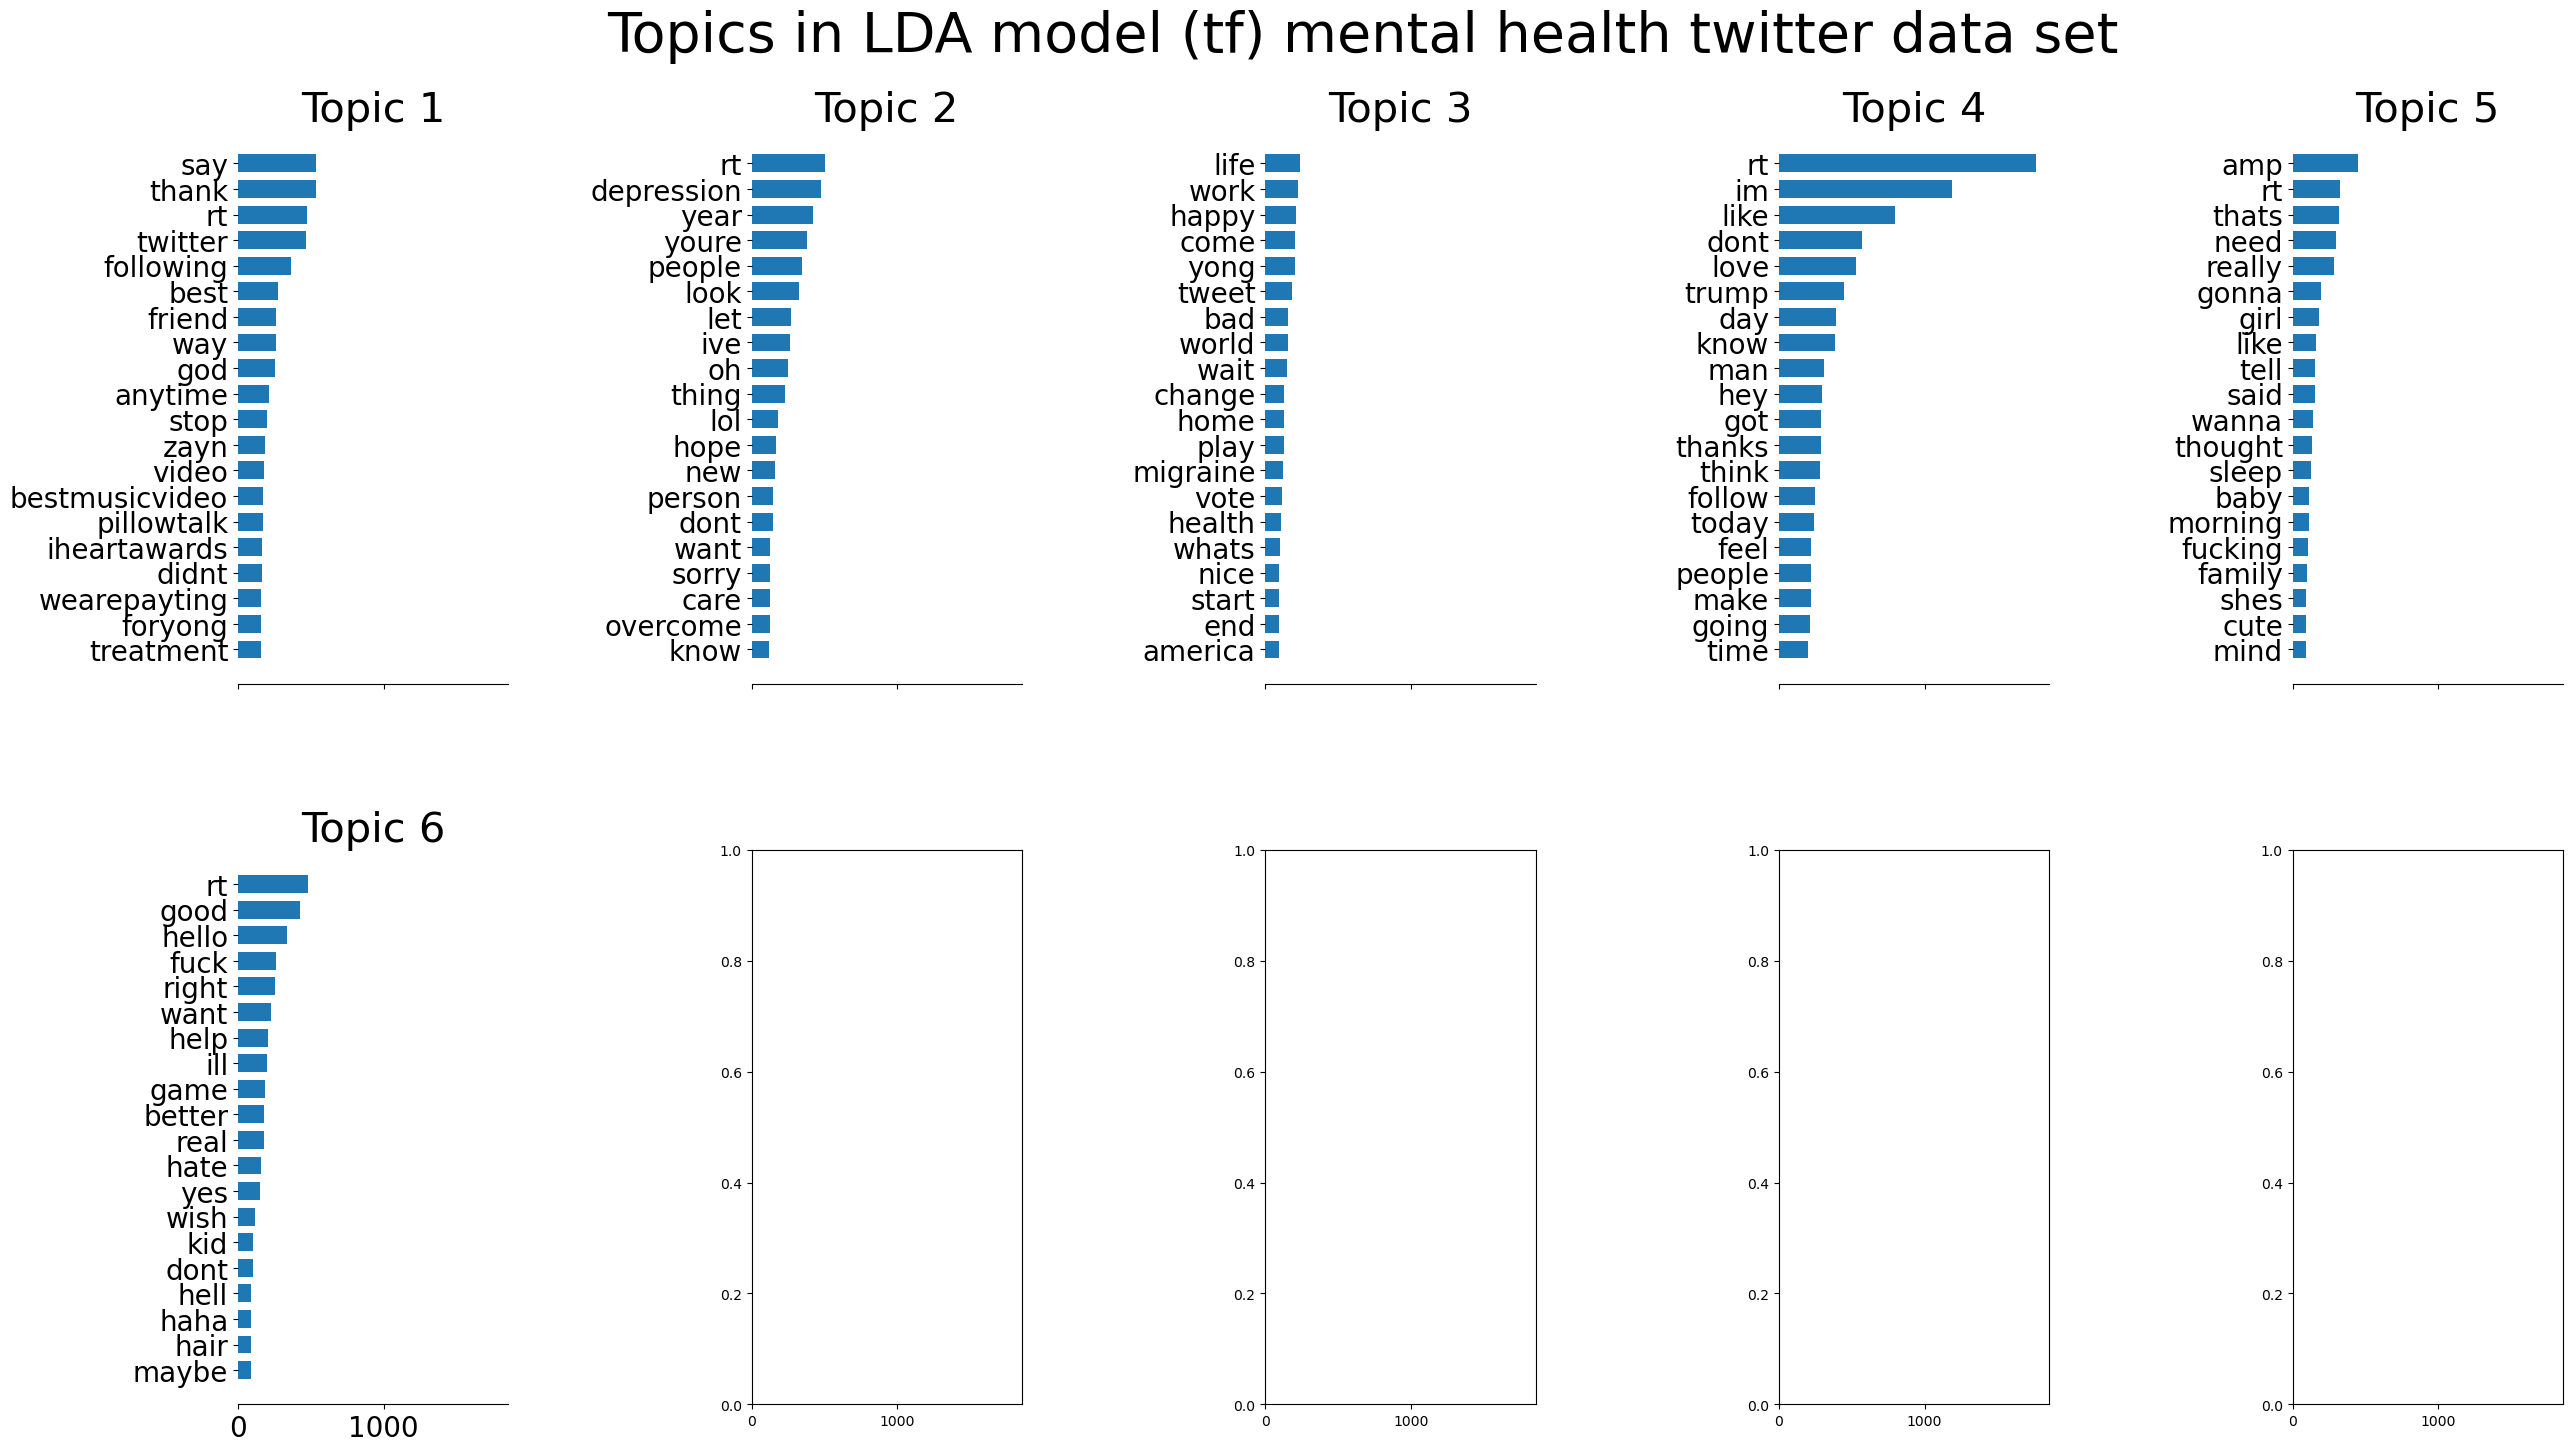

In [22]:
text_data = get_data('text_data/Mental-Health-Twitter.csv','post_text',20000)
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tfidf = tfidf_vectorizer.fit_transform(text_data)

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tf = tf_vectorizer.fit_transform(text_data)

print(tfidf.shape)
print(tf.shape)
#joblib.dump(vectorizer,"exports/text_vectorizer.pkl")
fit_models(tfidf,tf,tfidf_vectorizer,tf_vectorizer, " mental health twitter data set")

(120000, 2000)
(120000, 2000)
done in 23.038s.


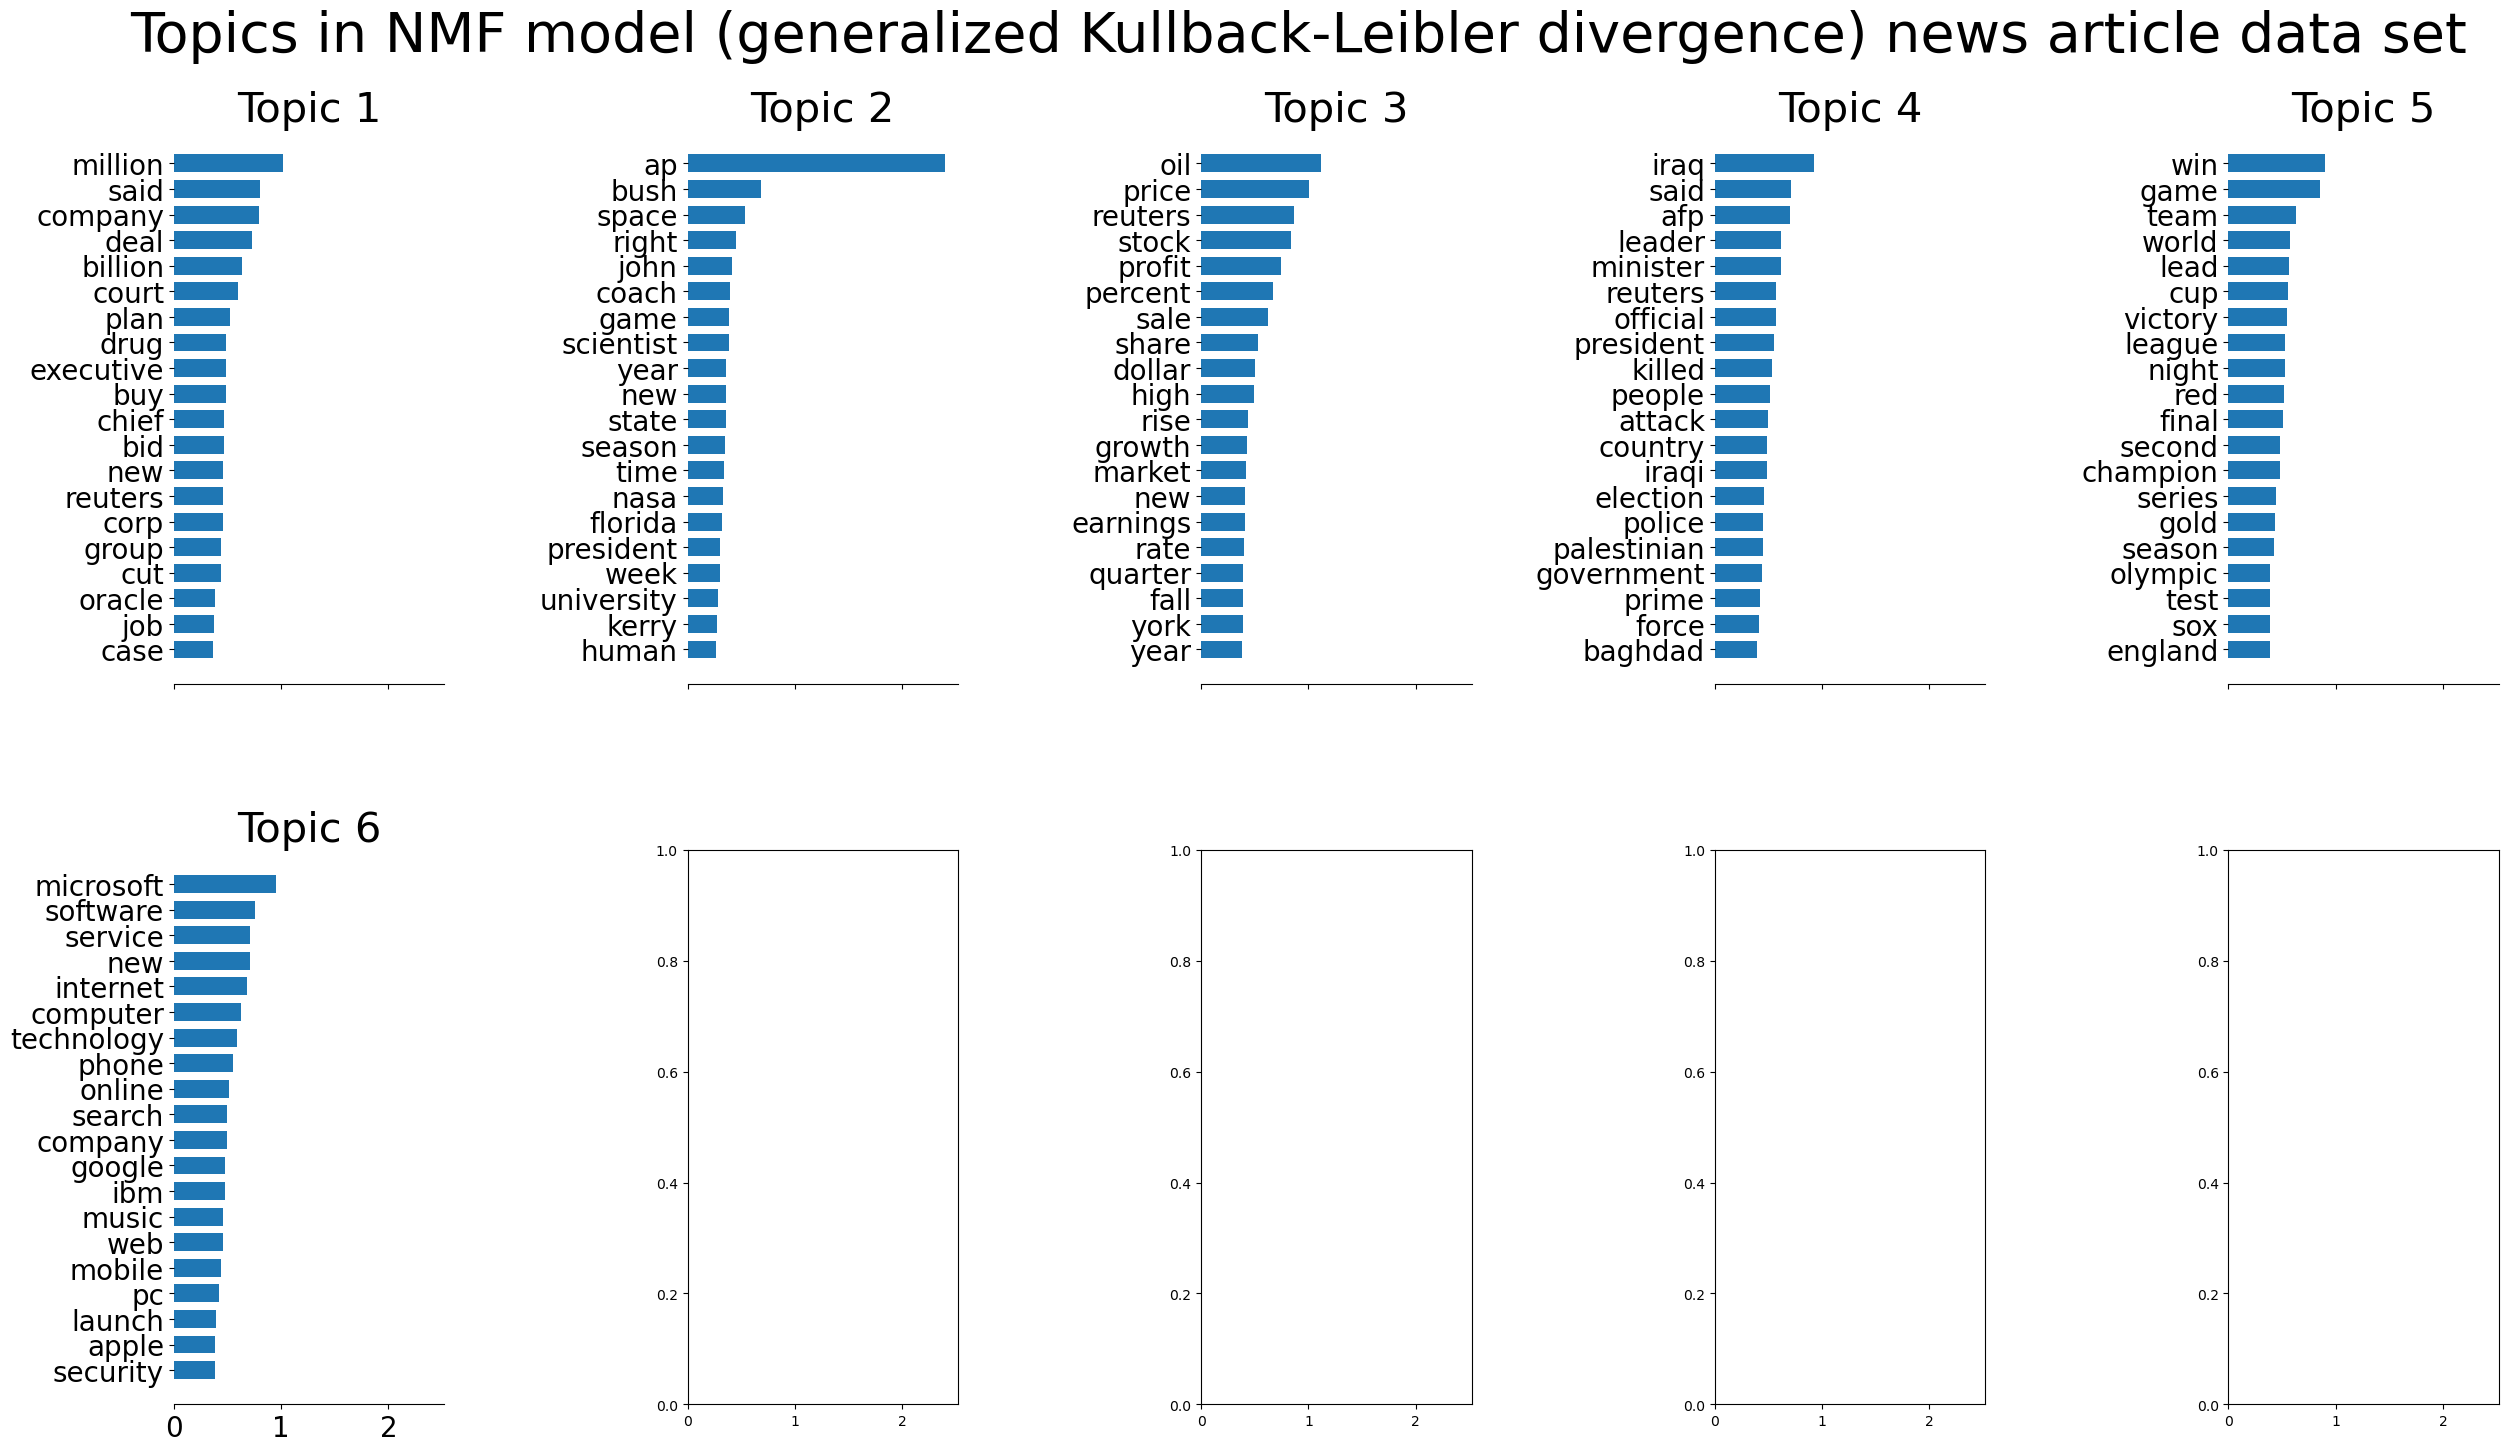

done in 59.616s.


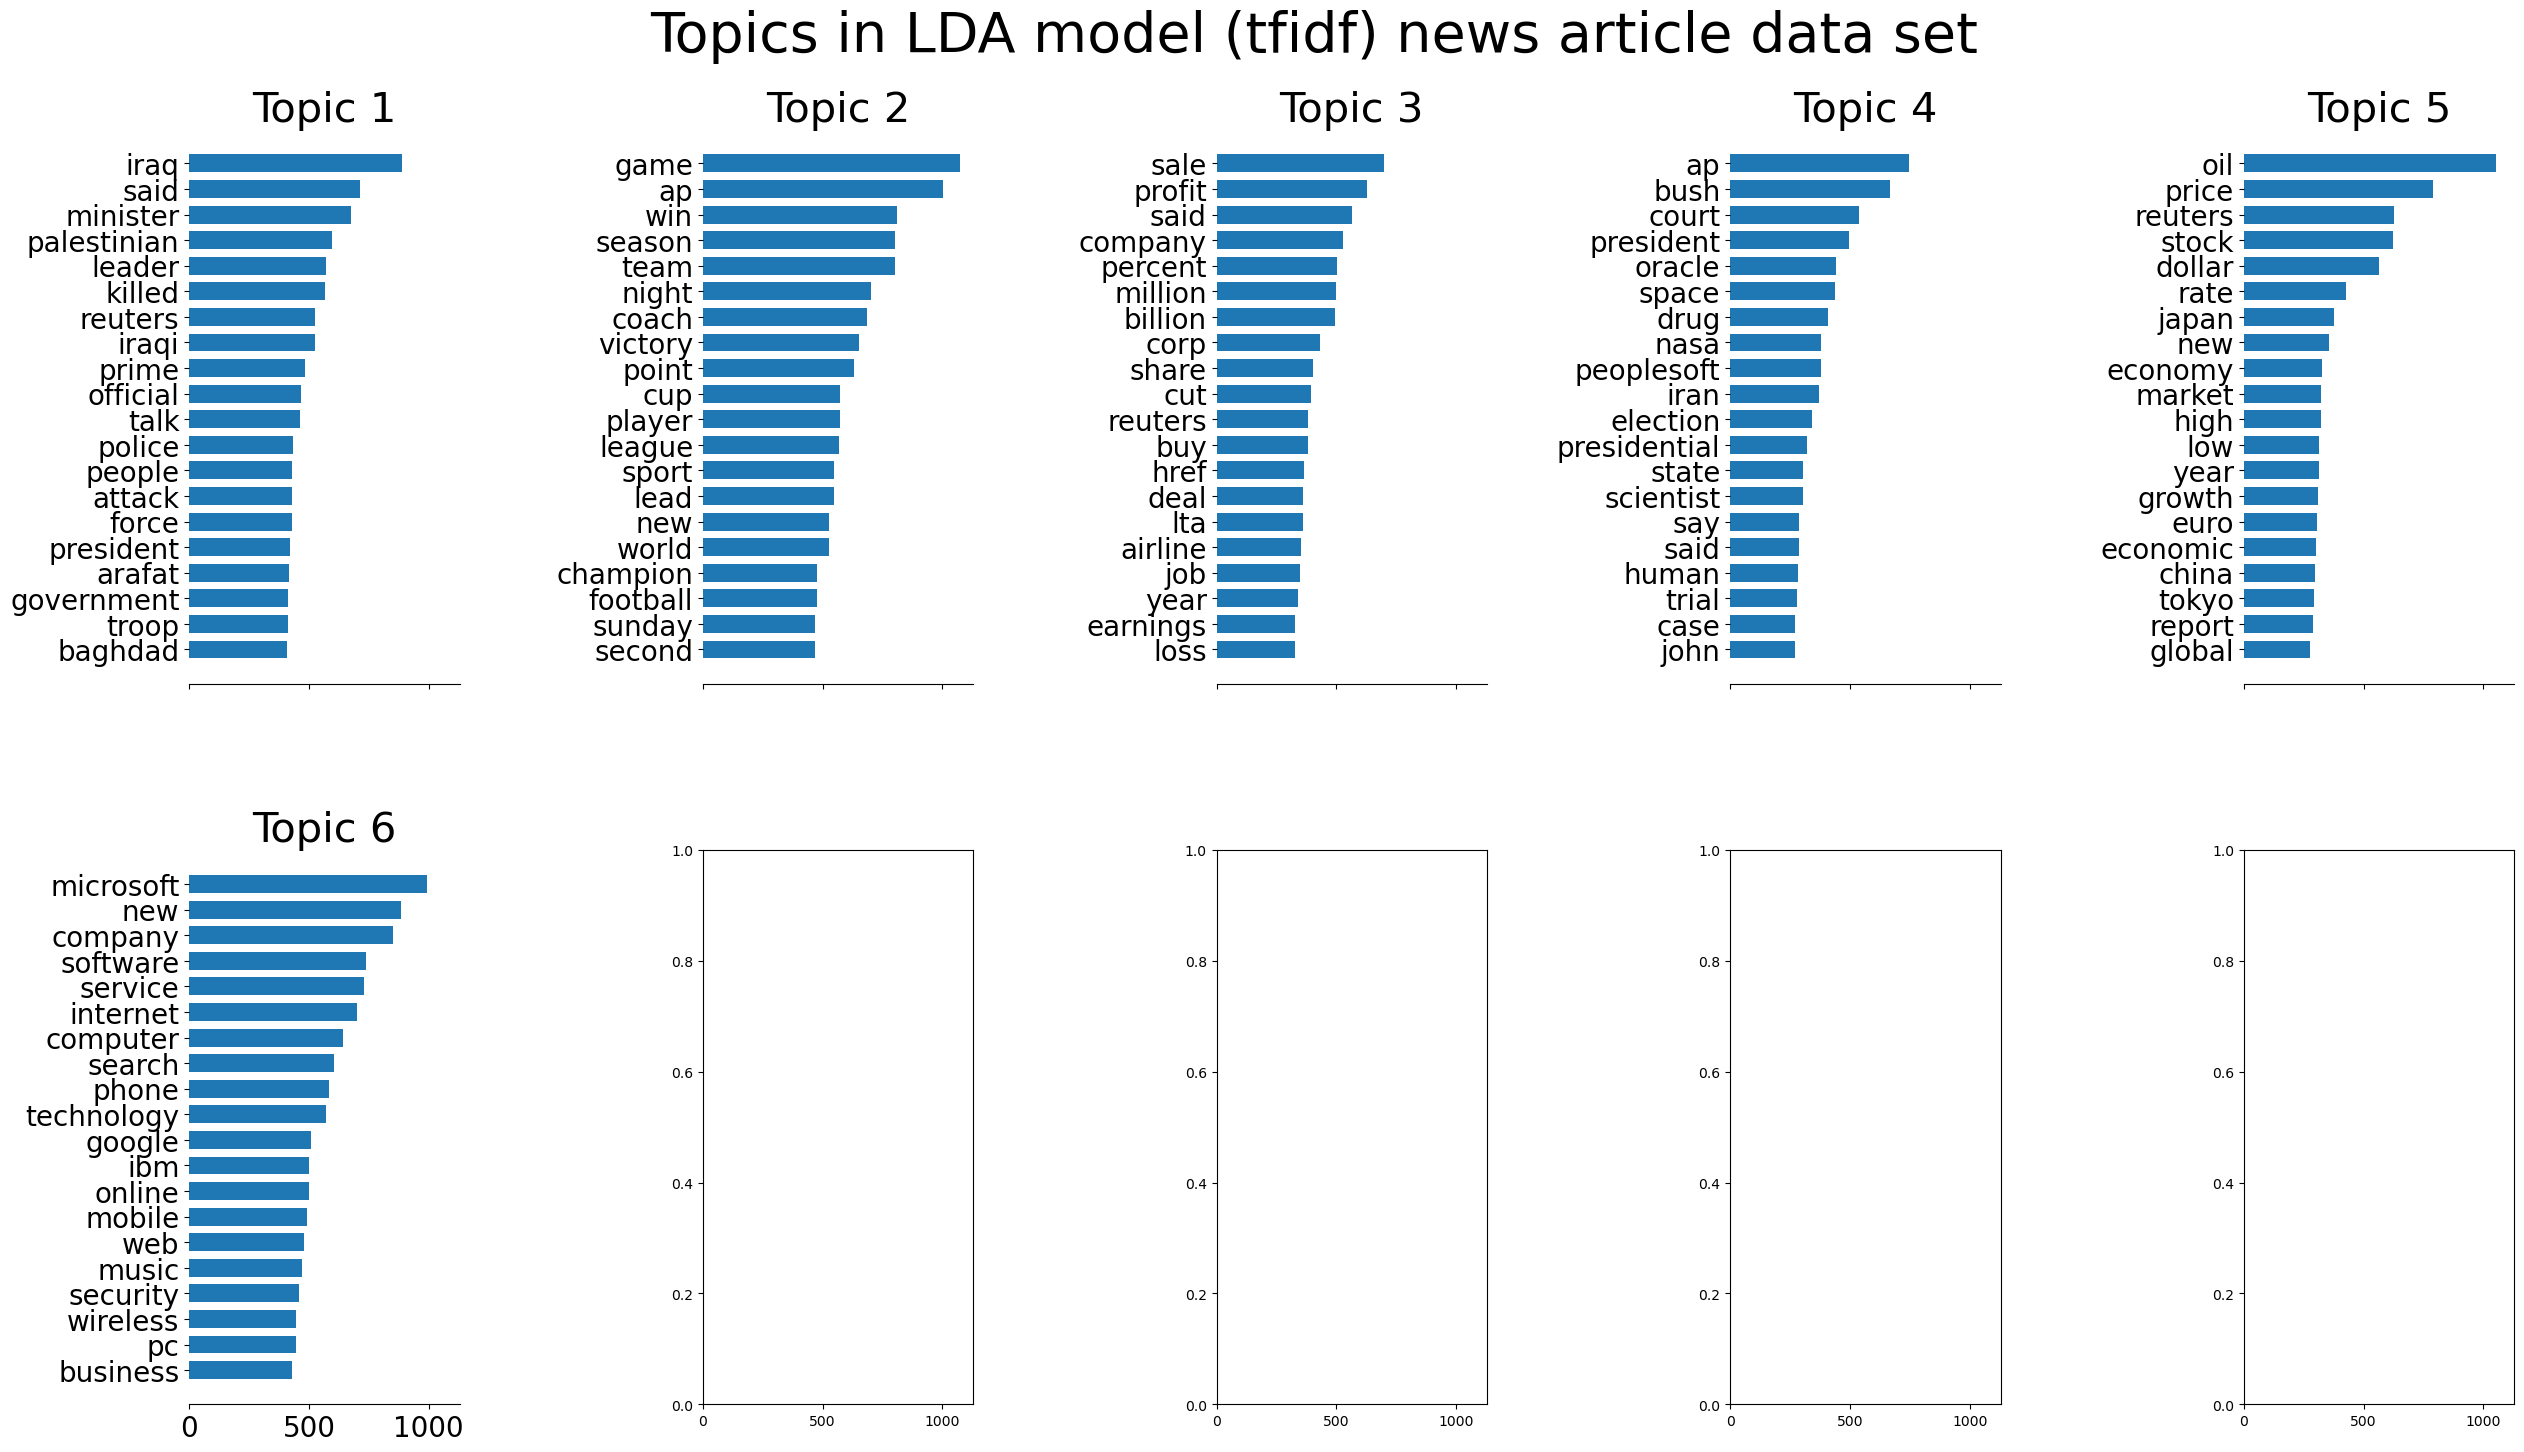

done in 76.415s.


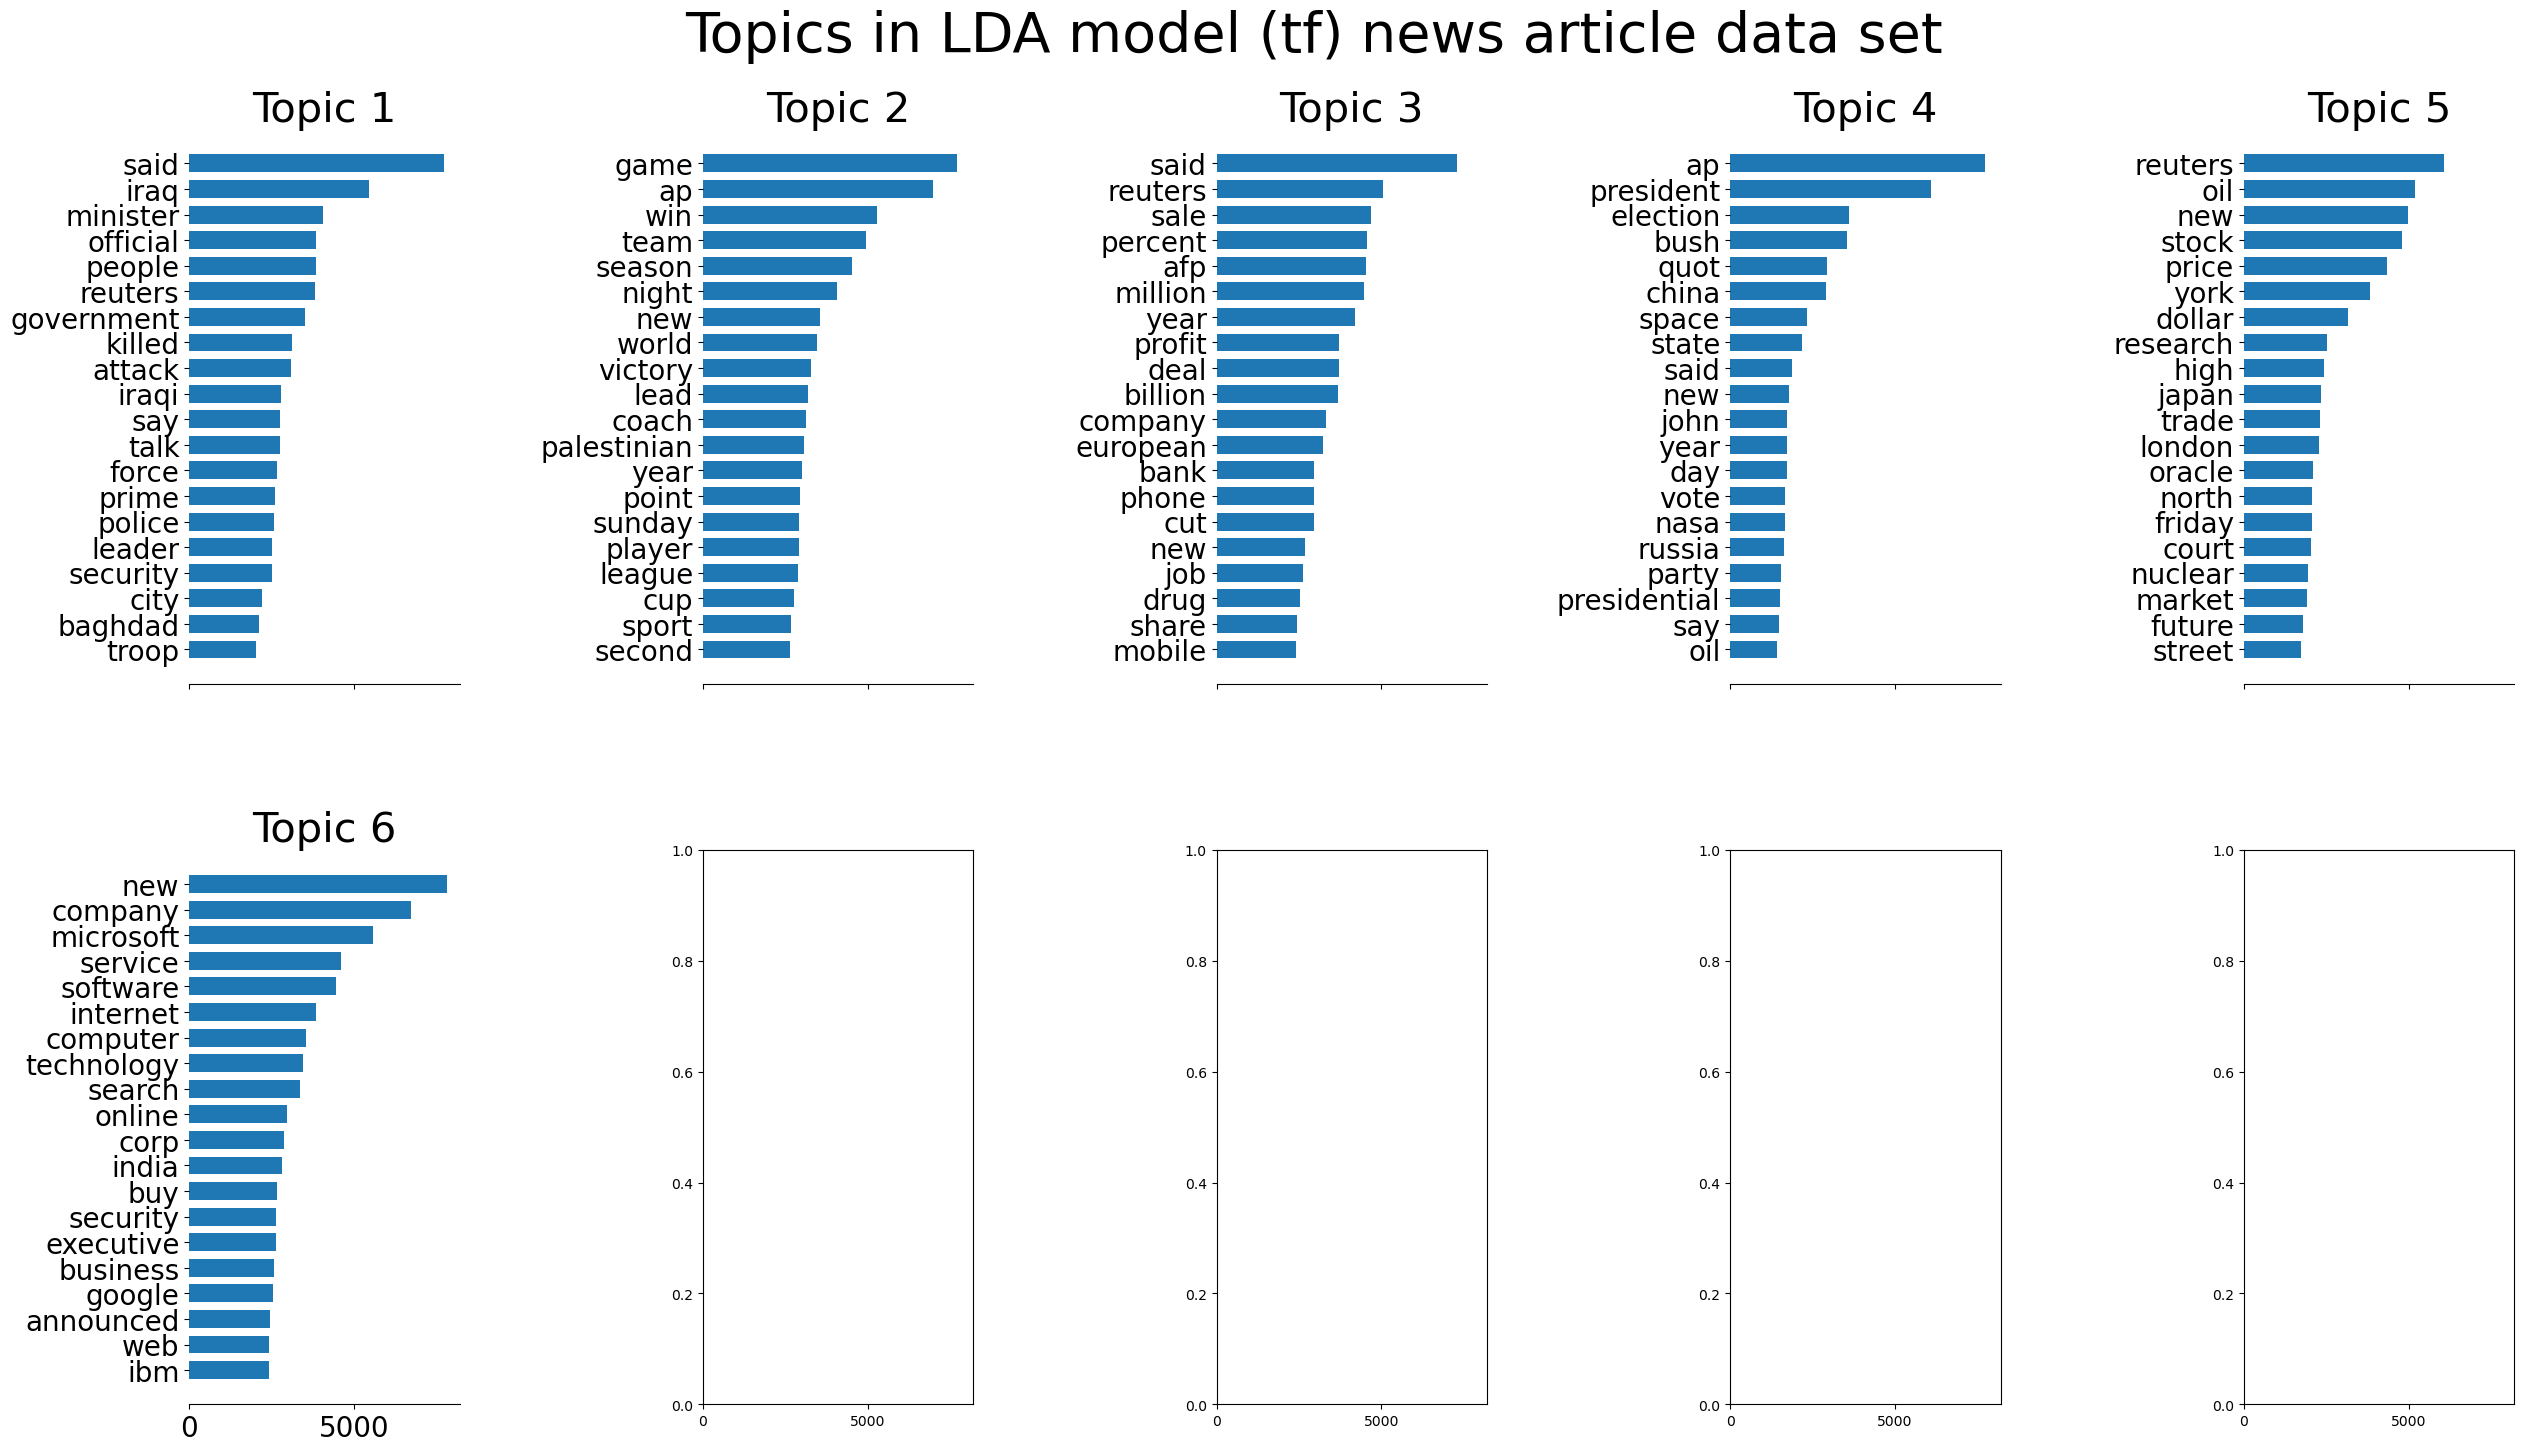

In [24]:
text_data = get_data('text_data/news_article.csv','text',120000)
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tfidf = tfidf_vectorizer.fit_transform(text_data)

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tf = tf_vectorizer.fit_transform(text_data)

print(tfidf.shape)
print(tf.shape)
#joblib.dump(vectorizer,"exports/text_vectorizer.pkl")
fit_models(tfidf,tf,tfidf_vectorizer,tf_vectorizer, " news article data set")

(11110, 2000)
(11110, 2000)
done in 10.232s.


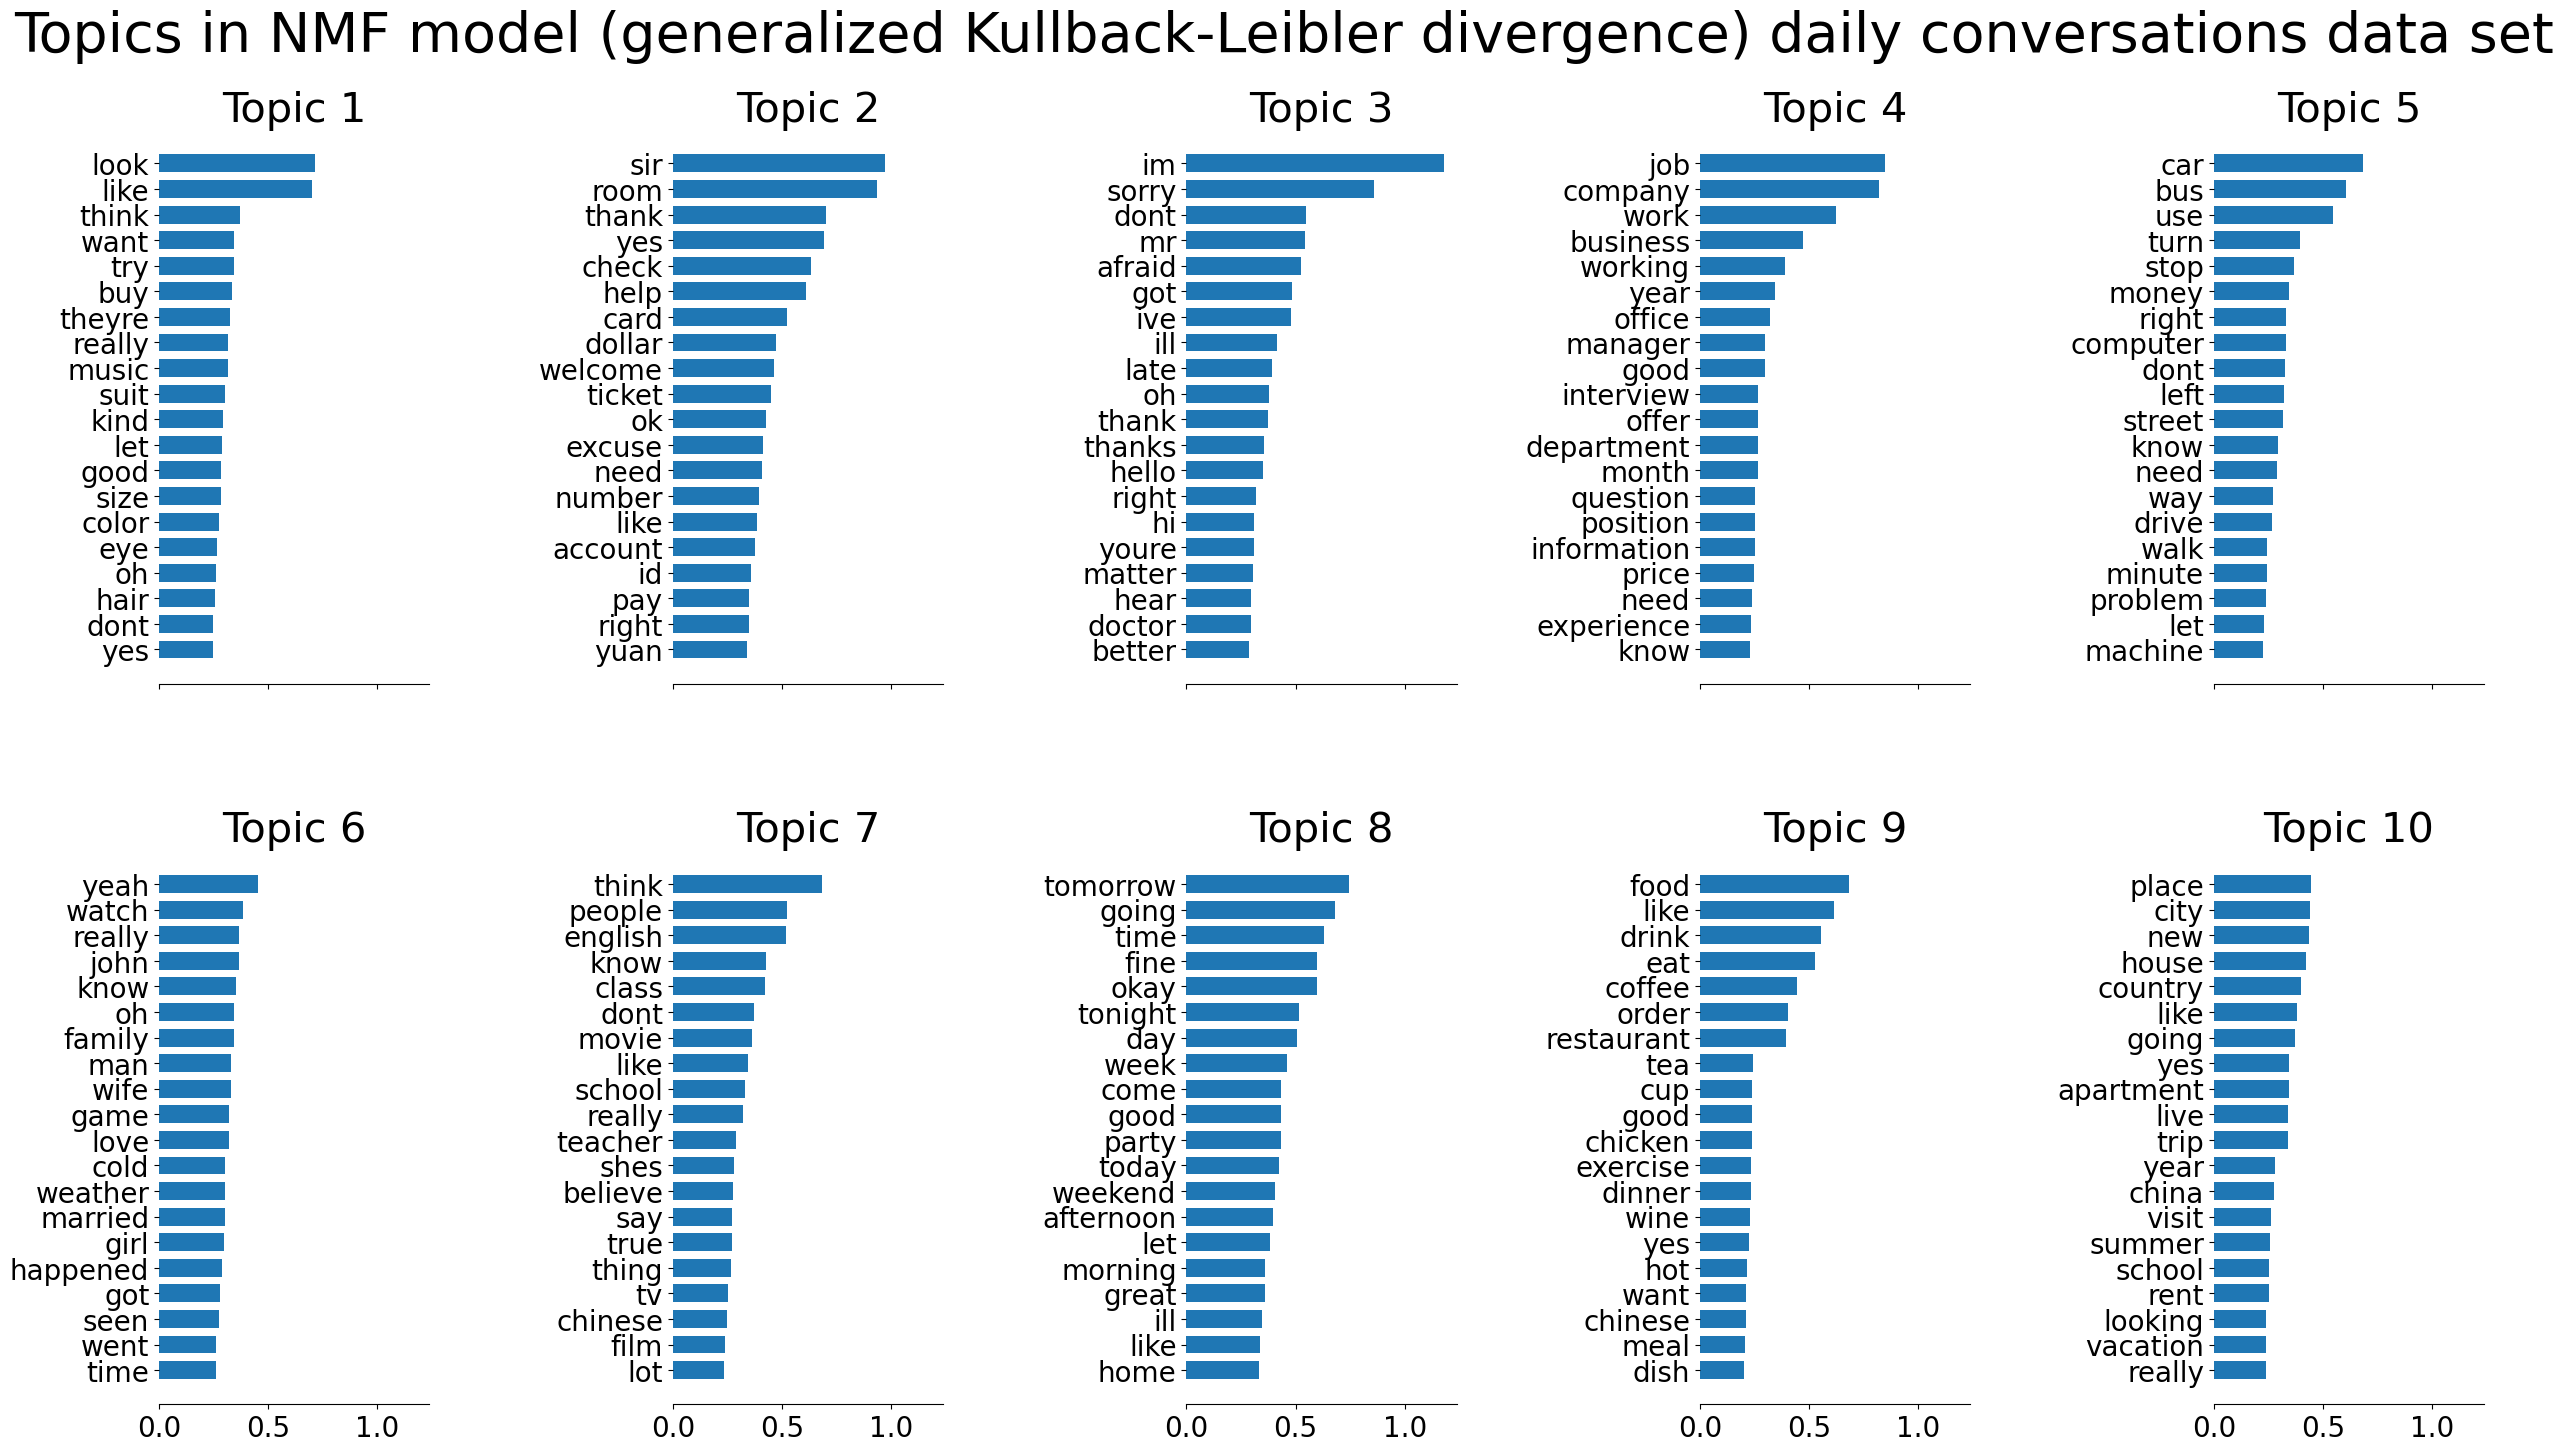

done in 7.120s.


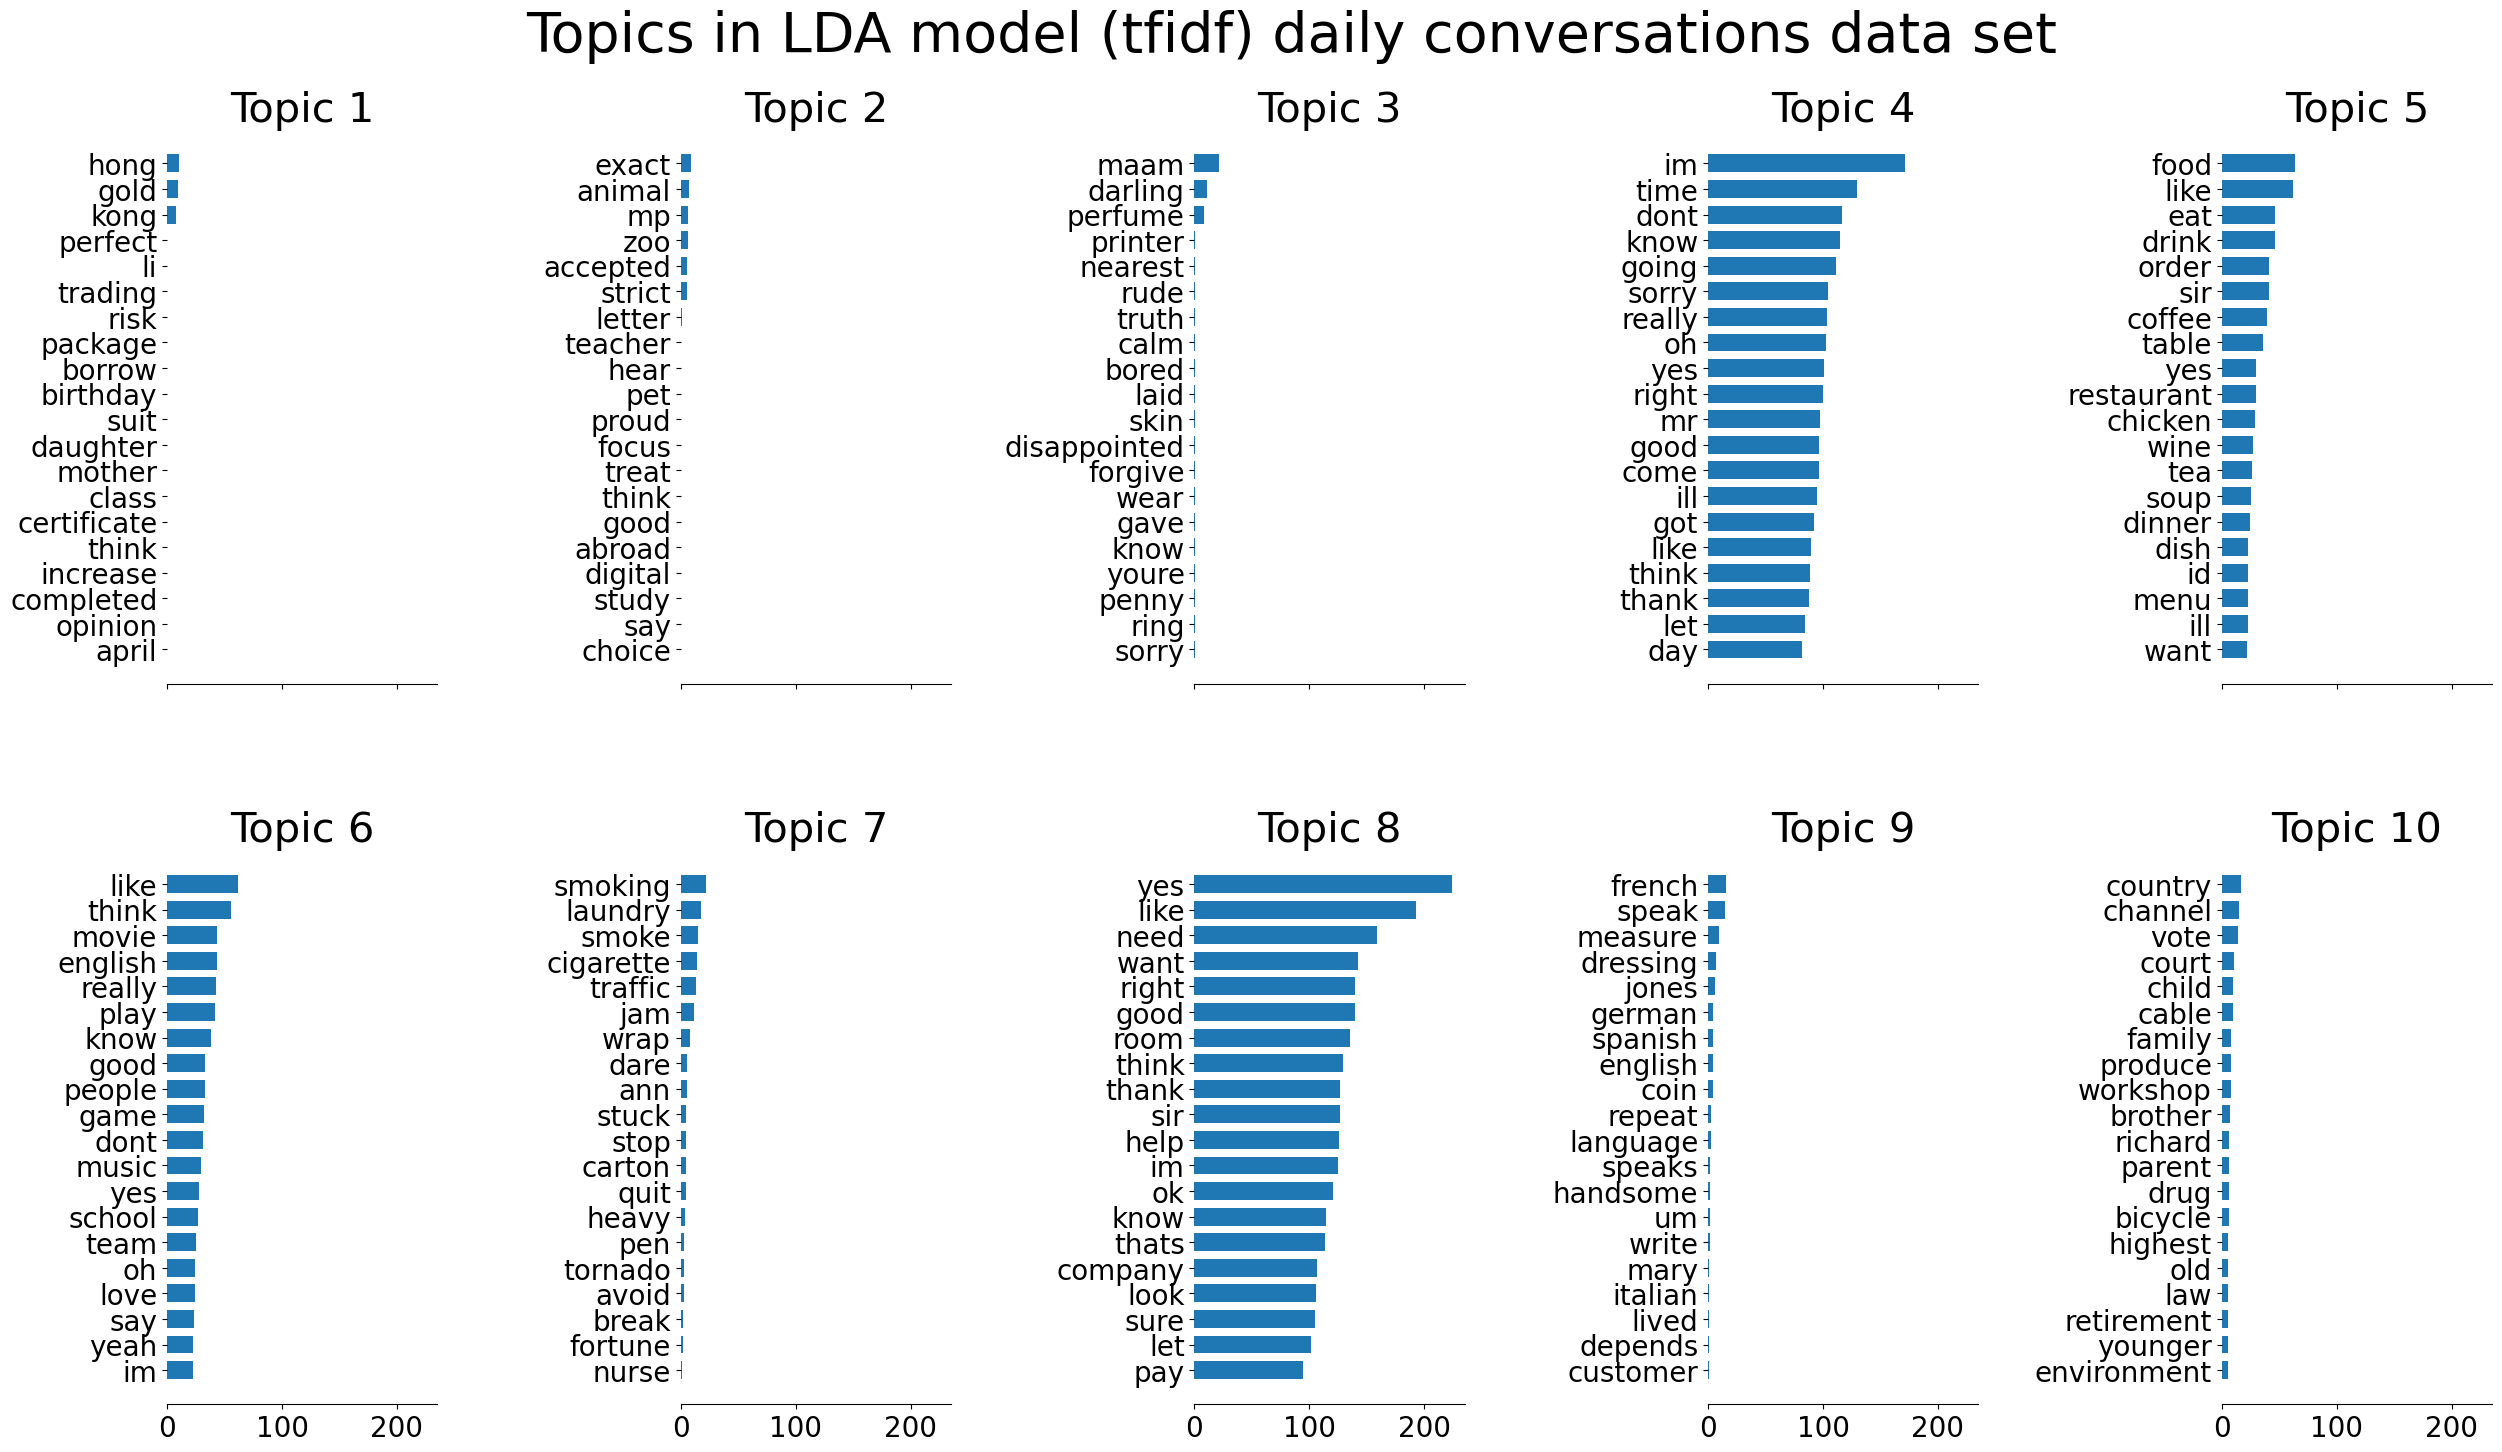

done in 12.797s.


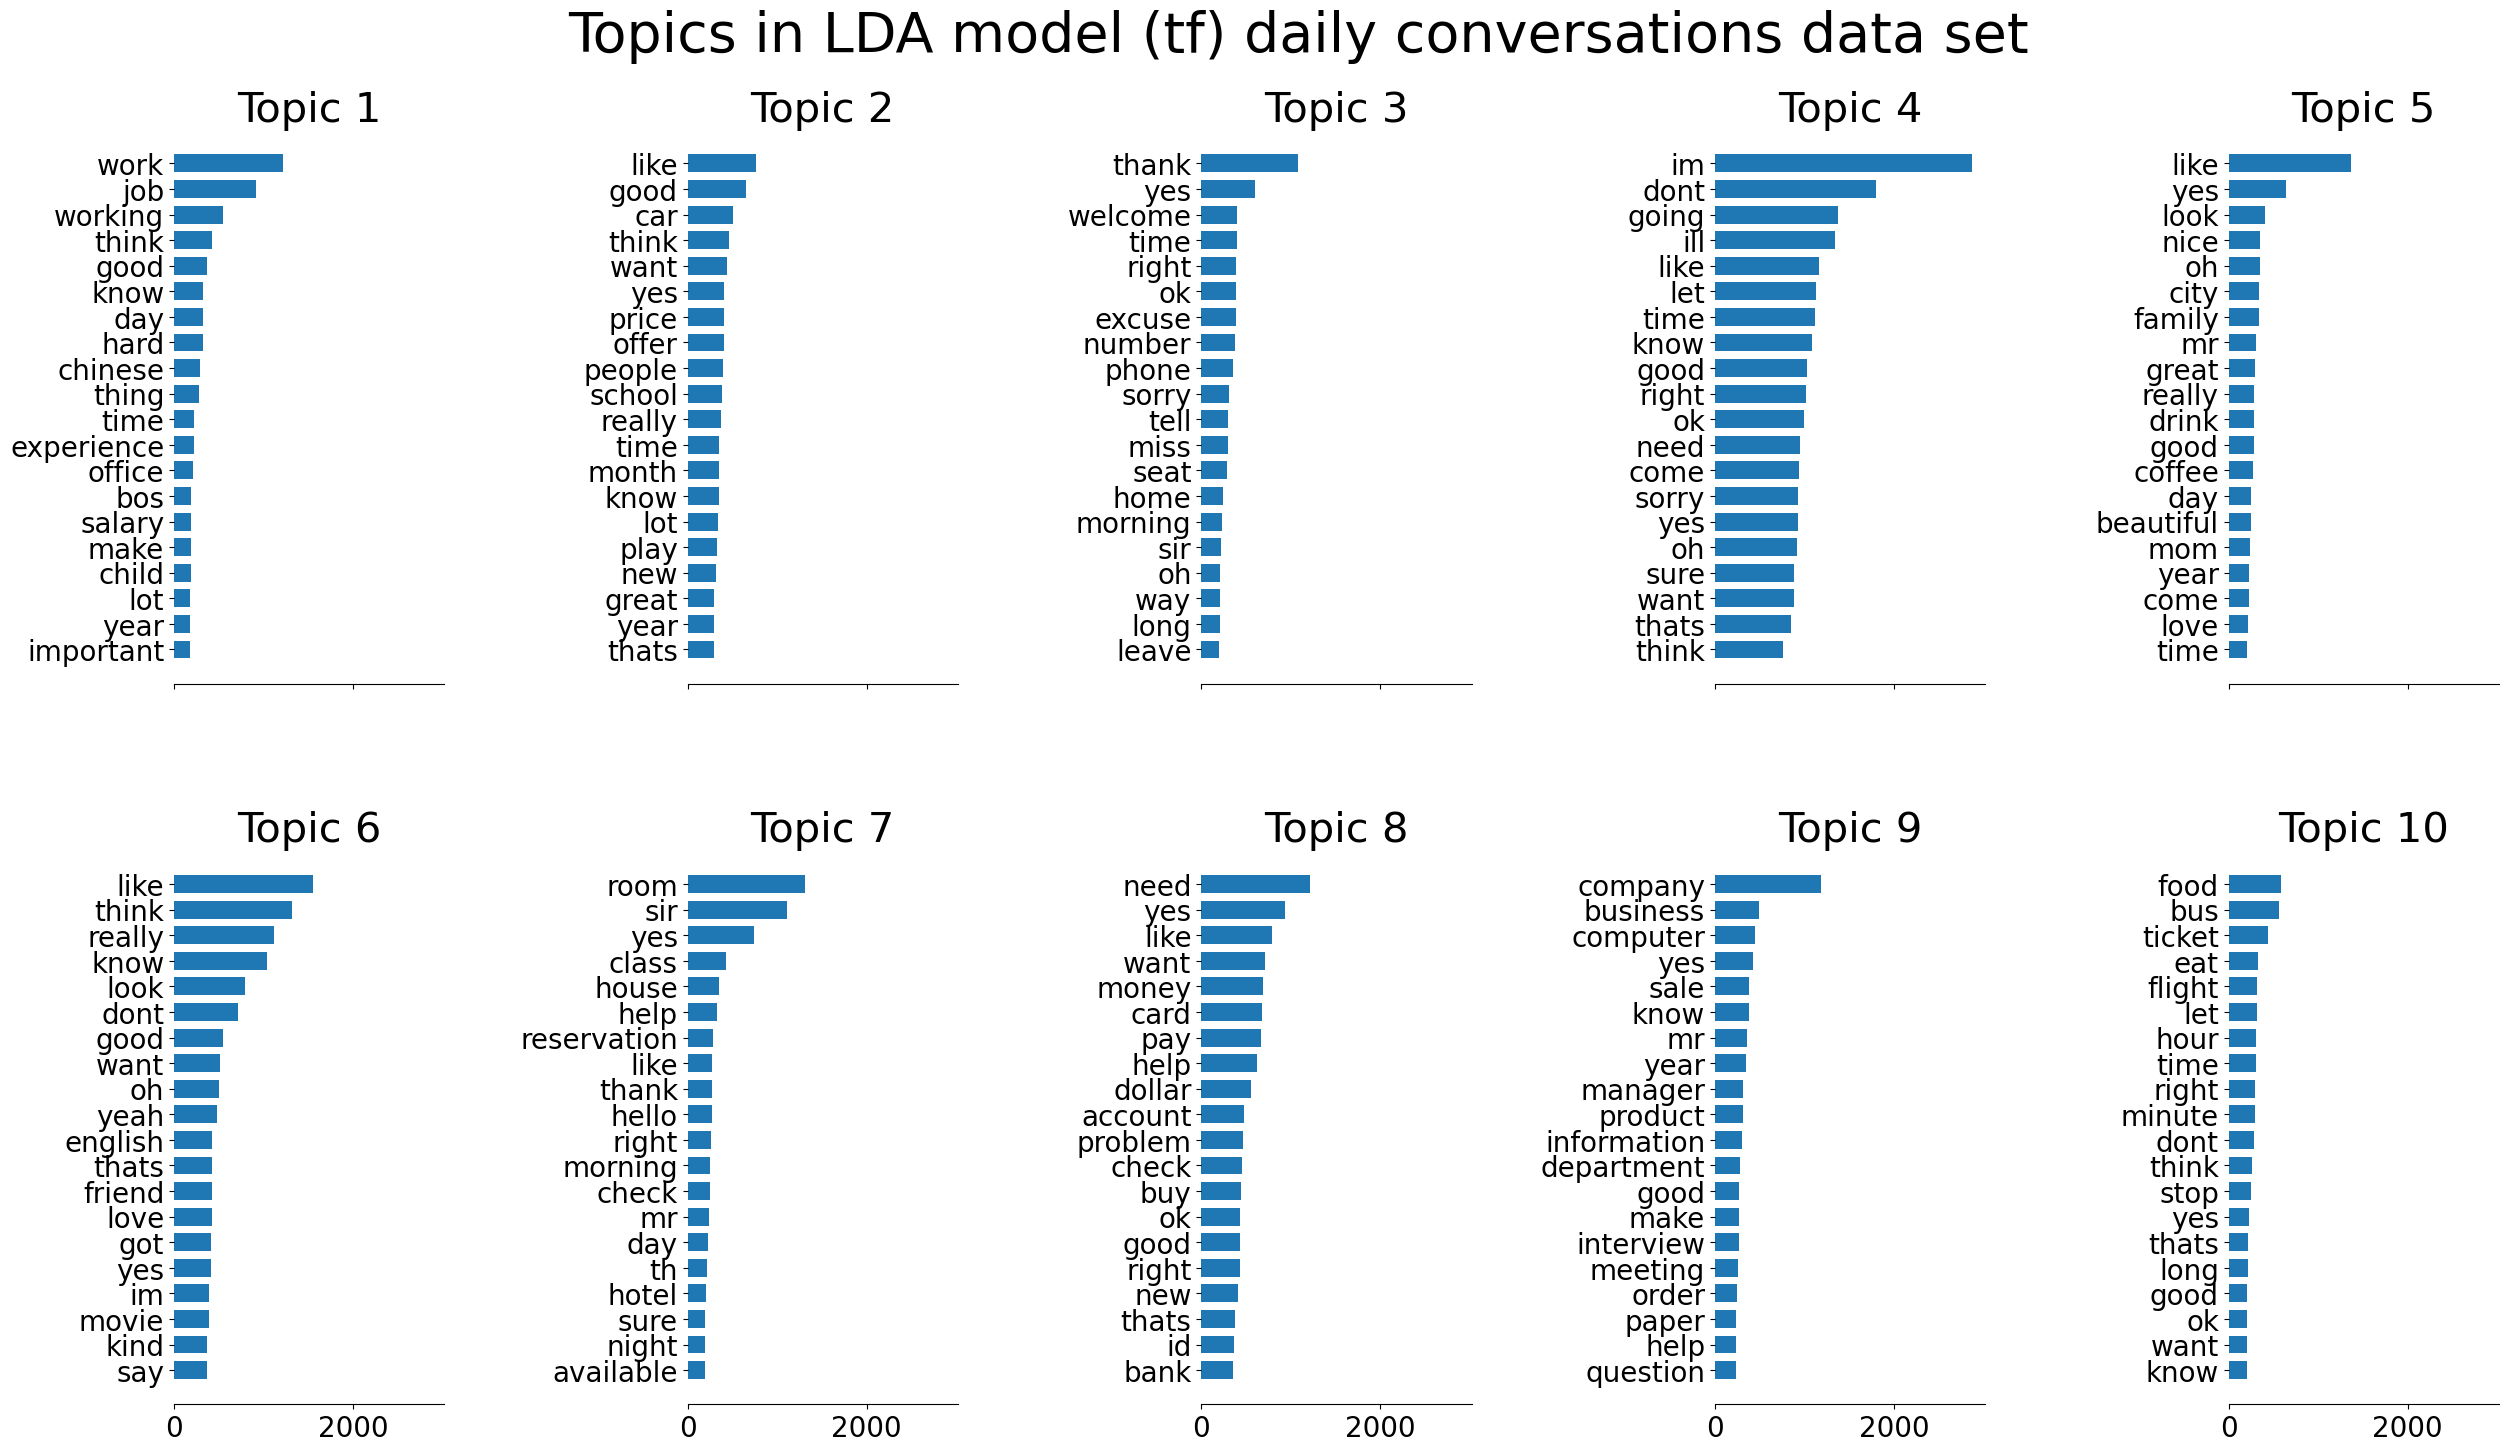

In [27]:
text_data = get_data('text_data/daily_conversations.csv','dialog',11110)
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tfidf = tfidf_vectorizer.fit_transform(text_data)

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tf = tf_vectorizer.fit_transform(text_data)

print(tfidf.shape)
print(tf.shape)
joblib.dump(tfidf_vectorizer,"exports/text_vectorizer.pkl")
print("vectorizer saved")
fit_models(tfidf,tf,tfidf_vectorizer,tf_vectorizer, " daily conversations data set")

Find important words in a new text example

In [24]:
new_text = ["I was walking through the park this morning it felt really relaxing."]
text_transform = vectorizer.transform(new_text)
feature_names = vectorizer.get_feature_names_out()
dense_array = text_transform.toarray()[0]  # Convert to array
word_tfidf = {feature_names[i]: dense_array[i] for i in range(len(feature_names)) if dense_array[i] > 0}

# Print results
print("TF-IDF Values for New Text:")
for word, tfidf_value in word_tfidf.items():
    print(f"{word}: {tfidf_value:.4f}")

TF-IDF Values for New Text:
felt: 0.3184
morning: 0.3607
park: 0.5140
really: 0.2271
relaxing: 0.5274
walking: 0.4178


Encoding that does not work as the matrix is sparse

In [26]:
rbm = BernoulliRBM(n_components=3, learning_rate=0.001,n_iter=3, random_state=0, verbose=True) #not working because of sparse matrix
rbm.fit(tfidf)
text_encoded = rbm.transform(text_transform)
print(text_encoded)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -2470.15, time = 1.31s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -1855.46, time = 1.29s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -1454.86, time = 1.31s
[[0.8903205  0.88946122 0.89155052]]


Encoding useing dimesionality reduction for sparse matrix

In [27]:
svd = TruncatedSVD(n_components=4, n_iter=10) #dimensionality reduction specific for sparsse matrices
svd.fit(tfidf)
joblib.dump(svd,"exports/svd_model_text.pkl")
print("svd modle saved")
text_encoded = svd.transform(text_transform)
print(text_encoded)
print(svd.explained_variance_ratio_.sum())

svd modle saved
[[ 0.05607067 -0.00556977 -0.05312226  0.04916409]]
0.02315333524127786


In [66]:
#to do add visualisation for several encoding of new text captions